# **Initialization**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Hide all warnings
warnings.filterwarnings('ignore')

In [6]:
# Filepath init
filepath = 'https://github.com/gr-oll/susFin/raw/refs/heads/main/Data/'

# **Exercise 1**

In [4]:
# Install openpyxl if not already installed
#%pip install openpyxl
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# Extracting the data and formatting the dataset
monthly_return = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
monthly_return_melted = monthly_return.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
monthly_return_melted.rename(columns={'NAME': 'Name'}, inplace=True)

In [7]:
# Extracting the country-region dataset and merging it to the previous one
static = pd.read_excel(filepath + 'Static.xlsx')
df_ex1 = pd.merge(monthly_return_melted, static, on=['Name','ISIN'], how='outer')

In [8]:
# Filtering the rows of interest
df_ex1 = df_ex1[df_ex1['Region'] == 'PAC']
df_ex1 = df_ex1[(pd.to_datetime(df_ex1['year']) >= '2013-12-31') & (pd.to_datetime(df_ex1['year']) <= '2023-12-31')]

In [9]:
# Sorting to facilitate comprehension
df_ex1.sort_values(by=['Name', 'year'], inplace=True)

In [10]:
# New col with percentage change between two months
df_ex1['individual_monthly_return'] = df_ex1.groupby('Name')['monthly_return'].pct_change()

In [11]:
df_ex1

,Name,ISIN,year,monthly_return,Country,Region,individual_monthly_return
1074,77 BANK,JP3352000008,2013-12-31 00:00:00,0.68,JP,PAC,NaN
1075,77 BANK,JP3352000008,2014-01-31 00:00:00,0.66,JP,PAC,-0.029412
1076,77 BANK,JP3352000008,2014-02-28 00:00:00,0.62,JP,PAC,-0.060606
1077,77 BANK,JP3352000008,2014-03-31 00:00:00,0.64,JP,PAC,0.032258
1078,77 BANK,JP3352000008,2014-04-30 00:00:00,0.64,JP,PAC,0.000000
...,...,...,...,...,...,...,...
770389,YUEXIU PROPERTY COMPANY,HK0000745908,2023-08-31 00:00:00,62.82,HK,PAC,-0.055906
770390,YUEXIU PROPERTY COMPANY,HK0000745908,2023-09-29 00:00:00,58.43,HK,PAC,-0.069882
770391,YUEXIU PROPERTY COMPANY,HK0000745908,2023-10-31 00:00:00,54.23,HK,PAC,-0.071881
770392,YUEXIU PROPERTY COMPANY,HK0000745908,2023-11-30 00:00:00,47.52,HK,PAC,-0.123732


In [12]:
# Dropping the 31.12.2013 rows (not included in our timeframe but necessary for the pct_change of 31.12.2014)
df_ex1 = df_ex1[pd.to_datetime(df_ex1['year']).dt.year >= 2014]

In [13]:
# Filtering by non missing escores (2013-2024) complete dataset to allow comparisons
escore = pd.read_excel(filepath + 'DS_EScore_Y.xlsx')
melted_escore = escore.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="escore")
melted_escore.rename(columns={'NAME': 'Name'}, inplace=True)
melted_escore['year'] = pd.to_datetime(melted_escore['year'], format='%Y')
escore_interest = pd.merge(melted_escore, static, how='outer')
escore_interest = escore_interest[(escore_interest['year'] >= '2013-01-01') & (melted_escore['year'] <= '2024-12-31')]
escore_interest = escore_interest[escore_interest['Region'] == 'PAC']

In [14]:
filtered = escore_interest.groupby('ISIN')['escore'].count().reset_index()
filtered = filtered[filtered['escore'] == 11]

In [15]:
interest_companies = filtered['ISIN'].tolist()

In [16]:
# Filtering df_ex1 to include only non missing escores
df_ex1 = df_ex1[df_ex1['ISIN'].isin(interest_companies)]

In [17]:
df_ex1[df_ex1['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,Country,Region,individual_monthly_return
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29 00:00:00,NaN,JP,PAC,0.0
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31 00:00:00,NaN,JP,PAC,0.0
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30 00:00:00,NaN,JP,PAC,0.0
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29 00:00:00,NaN,JP,PAC,0.0
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29 00:00:00,NaN,JP,PAC,0.0


In [18]:
# Individual handling of the 5 missings
df_ex1['individual_monthly_return'].loc[592512] = -1.
df_ex1['individual_monthly_return'].loc[592513] = np.nan
df_ex1['individual_monthly_return'].loc[592514] = np.nan
df_ex1['individual_monthly_return'].loc[592515] = np.nan
df_ex1['individual_monthly_return'].loc[698819] = -1.


In [19]:
# Creation of the averaged returns and their std + merge
annualization_mean = df_ex1.groupby('Name')['individual_monthly_return'].mean()
annualization_mean = pd.DataFrame(annualization_mean)
annualization_mean.rename(columns={'individual_monthly_return': 'monthly_mean'}, inplace=True)

annualization_var = df_ex1.groupby('Name')['individual_monthly_return'].std()
annualization_var = pd.DataFrame(annualization_var)
annualization_var.rename(columns={'individual_monthly_return': 'monthly_std'}, inplace=True)

annualization = pd.merge(annualization_mean, annualization_var, on='Name', how='outer')

In [20]:
# Creation of annualized cols
annualization['annualized_mean'] = annualization['monthly_mean'] * 12
annualization['annualized_std'] = annualization['monthly_std'] * np.sqrt(12)

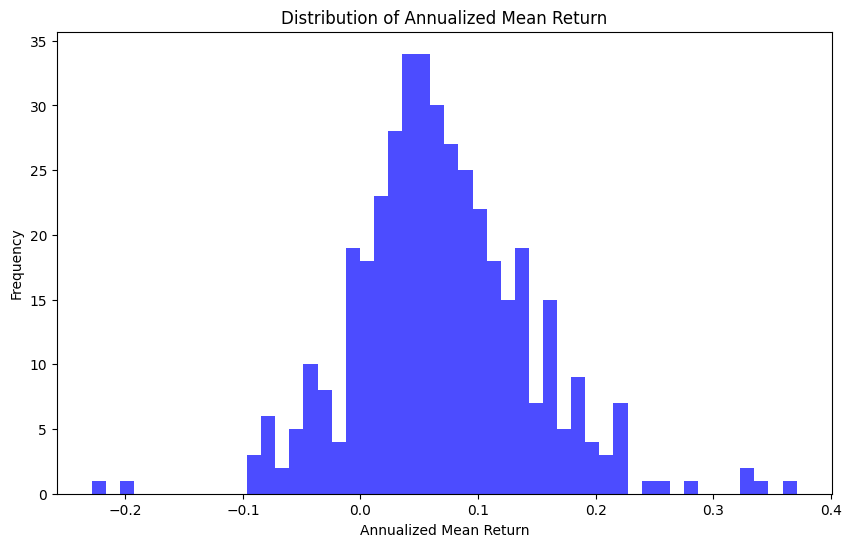

In [21]:
# Annualized mean histogram
plt.figure(figsize=(10, 6))
plt.hist(annualization['annualized_mean'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Annualized Mean Return')
plt.ylabel('Frequency')
plt.title('Distribution of Annualized Mean Return')
plt.show()

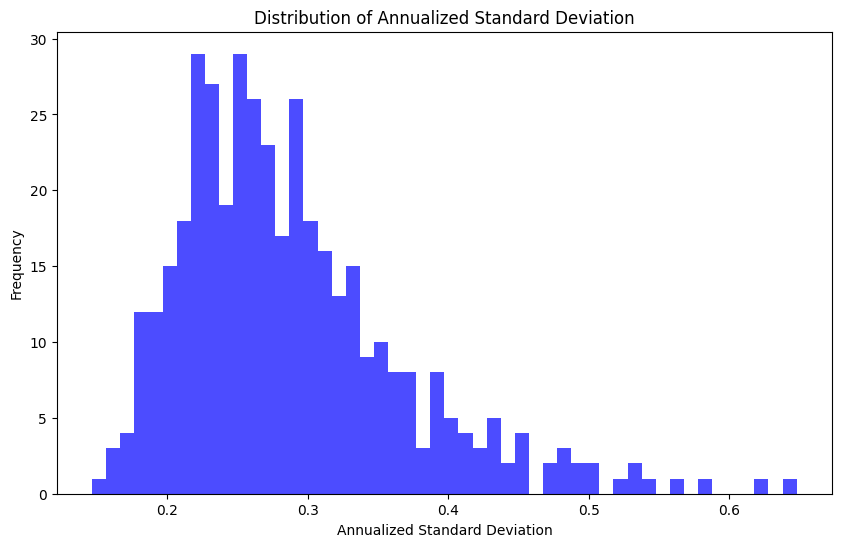

In [22]:
# Annualized std histogram
plt.figure(figsize=(10, 6))
plt.hist(annualization['annualized_std'], bins=50, color='blue', alpha=0.7)
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Frequency')
plt.title('Distribution of Annualized Standard Deviation')
plt.show()

In [23]:
# Variance-covariance matrix
np.corrcoef(annualization['annualized_mean'], annualization['annualized_std'])

array([[1.        , 0.08510139],
       [0.08510139, 1.        ]])

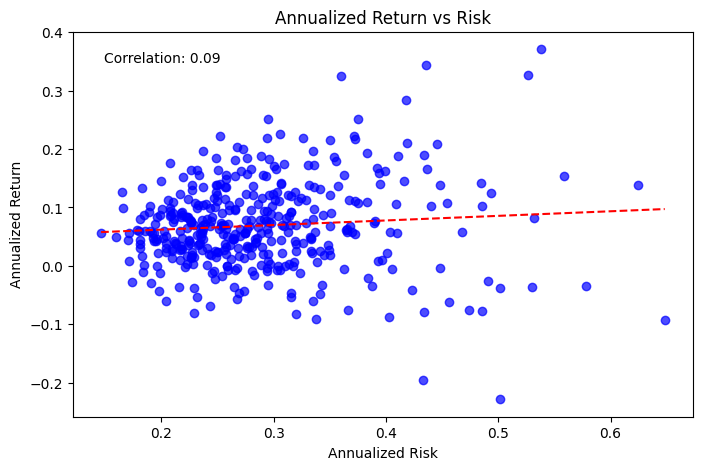

In [24]:
# Define annualized_returns DataFrame
annualized_returns = annualization[['annualized_std', 'annualized_mean']].rename(columns={'annualized_std': 'RISK', 'annualized_mean': 'RET_PCT'})

plt.figure(figsize=(8, 5))
plt.scatter(annualized_returns['RISK'], annualized_returns['RET_PCT'], color='blue', alpha=0.7)
plt.xlabel('Annualized Risk')
plt.ylabel('Annualized Return')
plt.title('Annualized Return vs Risk')

# Compute correlation
corr = annualized_returns['RISK'].corr(annualized_returns['RET_PCT'])

# Add a trendline
slope, intercept = np.polyfit(annualized_returns['RISK'], annualized_returns['RET_PCT'], 1)
x = np.linspace(annualized_returns['RISK'].min(), annualized_returns['RISK'].max(), 100)
y = slope * x + intercept
plt.plot(x, y, color='red', linestyle='--', label='Trendline')

# Display correlation on the plot
plt.text(
    0.05, 0.95,
    f'Correlation: {corr:.2f}',
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top'
)

plt.show()

# **Exercise 2**

In [25]:
# Extracting and merging monthly datasets
#monthly returns with dididend payments
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
melted_M_ret = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
melted_M_ret['year'] = pd.to_datetime(melted_M_ret['year'], format='%Y-%m-%d')
#monthly market value
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')
melted_M_mval = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_market_value")
melted_M_mval['year'] = pd.to_datetime(melted_M_mval['year'], format='%Y-%m-%d')


In [26]:
# Risk-free rates dataset
risk_free = pd.read_excel(filepath + 'Risk_Free_Rate.xlsx')
risk_free.rename(columns={'Unnamed: 0': 'year'}, inplace=True)
risk_free['year'] = pd.to_datetime(risk_free['year'], format='%Y%m')

In [27]:
# Merging the datasets
df_ex2 = pd.merge(melted_M_ret, melted_M_mval, on=['NAME', 'ISIN', 'year'], how='outer')
df_ex2.rename(columns={'NAME': 'Name'}, inplace=True)
df_ex2 = pd.merge(df_ex2, static, on=['Name', 'ISIN'], how='outer')

In [28]:
# Filter region and years of interest
df_ex2 = df_ex2[df_ex2['Region'] == 'PAC']
df_ex2 = df_ex2[(df_ex2['year'] >= '2013-12-31') & (df_ex2['year'] <= '2023-12-31')]
df_ex2['year'] = pd.to_datetime(df_ex2['year'])

In [29]:
# Filter same companies as in ex1 (non missing escores from 2013 to 2024)
df_ex2 = df_ex2[df_ex2['ISIN'].isin(interest_companies)]

In [30]:
df_ex2[df_ex2['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC


In [31]:
# Returns percentage change and drop the 31.12.2013 rows
df_ex2['pct_monthly_return'] = df_ex2.groupby('Name')['monthly_return'].pct_change()
df_ex2 = df_ex2[pd.to_datetime(df_ex2['year']).dt.year >= 2014]

In [32]:
# Individual handling of the 5 missings
df_ex2['pct_monthly_return'].loc[592512] = -1.
df_ex2['pct_monthly_return'].loc[592513] = np.nan
df_ex2['pct_monthly_return'].loc[592514] = np.nan
df_ex2['pct_monthly_return'].loc[592515] = np.nan
df_ex2['pct_monthly_return'].loc[698819] = -1.


In [33]:
df_ex2[df_ex2['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region,pct_monthly_return
592512,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC,-1.0
592513,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC,NaN
592514,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC,NaN
592515,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC,NaN
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC,-1.0


In [34]:
# Building the equally weighted portfolio
ew_pf = df_ex2.groupby('year')['pct_monthly_return'].sum().reset_index()

In [35]:
# Dividing the return by the number of assets for each month
ew_pf['ew_m_ret'] = 0
for month in df_ex2['year'].unique():
    ew_pf.loc[ew_pf['year'] == month, 'ew_m_ret'] = ew_pf.loc[ew_pf['year'] == month, 'pct_monthly_return'] / len(df_ex2[df_ex2['year'] == month]['Name'].unique())

In [36]:
# Calculate the market value share
df_ex2['mv_share'] = df_ex2['monthly_market_value'] / df_ex2.groupby('year')['monthly_market_value'].transform('sum')

In [37]:
# Weight the returns by the market value share shifted as in the exercise sheet
df_ex2['mv_return'] = df_ex2['pct_monthly_return'] * df_ex2['mv_share'].shift(1)

In [38]:
# Market value weighted portfolio
mw_pf = df_ex2.groupby('year')['mv_return'].sum().reset_index()

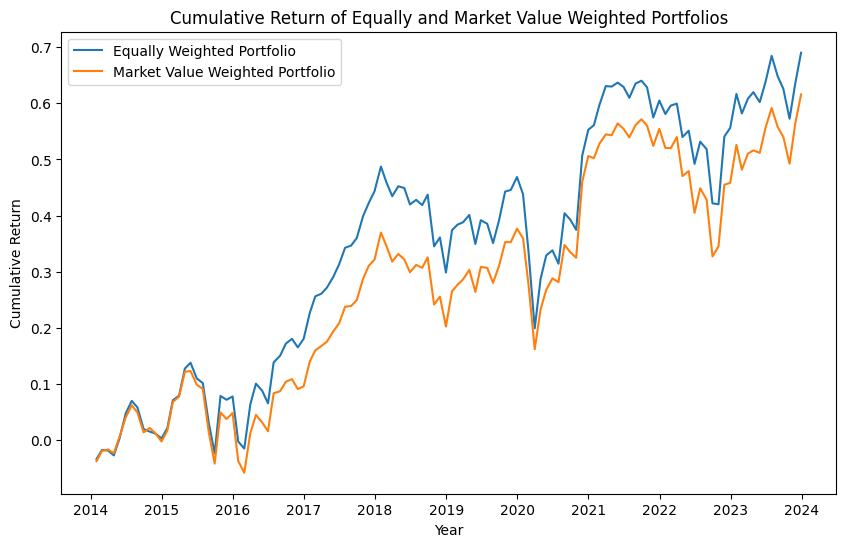

In [39]:
# Plot the monthly adapted returns for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(ew_pf['year'], ew_pf['ew_m_ret'].cumsum(), label='Equally Weighted Portfolio')
plt.plot(mw_pf['year'], mw_pf['mv_return'].cumsum(), label='Market Value Weighted Portfolio')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return of Equally and Market Value Weighted Portfolios')
plt.legend()
plt.show()

In [40]:
# Risk free rate in the given period 
risk_free = risk_free[(pd.to_datetime(risk_free['year']).dt.year >= 2014) & (pd.to_datetime(risk_free['year']).dt.year <= 2023)]
# Annualized risk free rate
ann_rf = risk_free['RF'].mean() * 12 / 100

In [41]:
# Statistics of interest Equally Weighted Portfolio
# Annualized return
ew_ann_ret = ew_pf['ew_m_ret'].mean() * 12
# Annualized std
ew_ann_std = ew_pf['ew_m_ret'].std() * np.sqrt(12)
#min return
ew_min_ret = ew_pf['ew_m_ret'].min()
#max return
ew_max_ret = ew_pf['ew_m_ret'].max()

# Statistics of interest Market Value Weighted Portfolio
# Annualized return
mw_ann_ret = mw_pf['mv_return'].mean() * 12
# Annualized std
mw_ann_std = mw_pf['mv_return'].std() * np.sqrt(12)
#min return
mw_min_ret = mw_pf['mv_return'].min()
#max return
mw_max_ret = mw_pf['mv_return'].max()


In [42]:
# Equally weighted Sharpe Ratio
ew_sharpe = (ew_ann_ret - ann_rf)/ ew_ann_std
ew_sharpe

np.float64(0.38387887979603225)

In [43]:
# Value weighted Sharpe Ratio
mw_sharpe = (mw_ann_ret - ann_rf)/ mw_ann_std
mw_sharpe


np.float64(0.35568049703395765)

In [44]:
statistics = pd.DataFrame({'Portfolio': ['Equally Weighted', 'Market Value Weighted'],
                           'Annualized Return': [ew_ann_ret, mw_ann_ret],
                           'Annualized Standard Deviation': [ew_ann_std, mw_ann_std],
                           'Sharpe Ratio': [ew_sharpe, mw_sharpe],
                           'Min Return': [ew_min_ret, mw_min_ret],
                           'Max Return': [ew_max_ret, mw_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Equally Weighted,0.069011,0.149373,0.383879,-0.136916,0.132389
1,Market Value Weighted,0.061567,0.140286,0.355680,-0.115458,0.135156


In [45]:
'''delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',
       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
       'CSR DEAD - DEAD.10/07/24', 'J S R DEAD - DELIST.25/06/24',
       'LAWSON DEAD - DELIST.24/07/24',
       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
       'TOSHIBA DEAD - DELIST.20/12/23']'''

"delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',\n       'BENESSE HOLDINGS DEAD - DELIST.17/05/24',\n       'CSR DEAD - DEAD.10/07/24', 'J S R DEAD - DELIST.25/06/24',\n       'LAWSON DEAD - DELIST.24/07/24',\n       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',\n       'TOSHIBA DEAD - DELIST.20/12/23']"

In [46]:
annualization = annualization.reset_index()

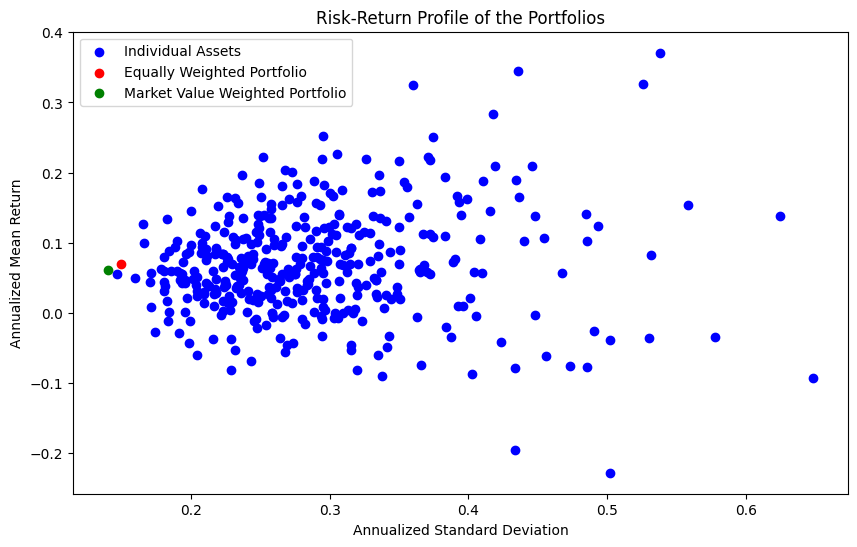

In [47]:
# Define the list of delisted companies
delisted = ['A2B AUSTRALIA DEAD - DELIST.12/04/24',
			'BENESSE HOLDINGS DEAD - DELIST.17/05/24',
			'CSR DEAD - DEAD.10/07/24', 
			'J S R DEAD - DELIST.25/06/24',
			'LAWSON DEAD - DELIST.24/07/24',
			'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23',
			'TOSHIBA DEAD - DELIST.20/12/23']

plt.figure(figsize=(10, 6))
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')
#plt.scatter(annualization[annualization['Name'].isin(delisted)]['annualized_std'], annualization[annualization['Name'].isin(delisted)]['annualized_mean'], color='cyan')
plt.scatter(ew_ann_std, ew_ann_ret, color='red', label='Equally Weighted Portfolio')
plt.scatter(mw_ann_std, mw_ann_ret, color='green', label='Market Value Weighted Portfolio')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Risk-Return Profile of the Portfolios')
plt.legend()
plt.savefig('riskreturn.png')
plt.show()

# **Exercise 3**

In [48]:
# Extracting and merging monthly datasets
#monthly returns with dididend payments
M_ret = pd.read_excel(filepath + 'DS_RI_USD_M.xlsx')
melted_M_ret = M_ret.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_return")
melted_M_ret['year'] = pd.to_datetime(melted_M_ret['year'], format='%Y-%m-%d')
#monthly market value
M_mval = pd.read_excel(filepath + 'DS_MV_USD_M.xlsx')
melted_M_mval = M_mval.melt(id_vars=["NAME", "ISIN"], var_name="year", value_name="monthly_market_value")
melted_M_mval['year'] = pd.to_datetime(melted_M_mval['year'], format='%Y-%m-%d')
# Merging the datasets
df_ex3 = pd.merge(melted_M_ret, melted_M_mval, on=['NAME', 'ISIN', 'year'], how='outer')
df_ex3.rename(columns={'NAME': 'Name'}, inplace=True)
df_ex3 = pd.merge(df_ex3, static, on=['Name', 'ISIN'], how='outer')
# Filter region and years of interest
df_ex3 = df_ex3[df_ex3['Region'] == 'PAC']
df_ex3 = df_ex3[(df_ex3['year'] >= '2012-12-31') & (df_ex3['year'] <= '2023-12-31')]


In [49]:
# Filter df_ex3 to the same companies of interest as before (non missing escore from 2013 to 2024)
df_ex3 = df_ex3[df_ex3['ISIN'].isin(interest_companies)]

In [50]:
# Ensure the 'year' column in escore is datetime type
melted_escore['year'] = pd.to_datetime(melted_escore['year'], format='%Y')

# Merge the dataframes using merge_asof to align yearly escore data with monthly df_ex3 data
df_ex3 = pd.merge_asof(df_ex3.sort_values('year'), 
                                melted_escore.sort_values('year'), 
                                by=['Name', 'ISIN'], 
                                on='year', 
                                direction='backward')

In [51]:
# Returns percentage change and drop the 31.12.2012 rows
df_ex3['pct_monthly_return'] = df_ex3.groupby('Name')['monthly_return'].pct_change()
df_ex3 = df_ex3[pd.to_datetime(df_ex3['year']).dt.year >= 2013]

In [52]:
df_ex3.sort_values(by=['Name', 'year'], inplace=True)

In [53]:
df_ex3 = df_ex3[(df_ex3['year'].dt.year != 2013) & (df_ex3['year'].dt.year != 2012)]

In [54]:
df_ex3[df_ex3['monthly_return'].isna()]

,Name,ISIN,year,monthly_return,monthly_market_value,Country,Region,escore,pct_monthly_return
52914,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-09-29,NaN,0.0,JP,PAC,63.93,0.0
53307,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-10-31,NaN,0.0,JP,PAC,63.93,0.0
53701,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-11-30,NaN,0.0,JP,PAC,63.93,0.0
54106,SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23,JP3729000004,2023-12-29,NaN,0.0,JP,PAC,63.93,0.0
54362,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,0.0,JP,PAC,89.52,0.0


In [55]:
# Individual handling of the 5 missings
df_ex3['pct_monthly_return'].loc[52914] = -1.
df_ex3['pct_monthly_return'].loc[53307] = np.nan
df_ex3['pct_monthly_return'].loc[53701] = np.nan
df_ex3['pct_monthly_return'].loc[54106] = np.nan
df_ex3['pct_monthly_return'].loc[54362] = -1.


In [56]:
# Create the variance-covariance matrix for pct_monthly_return
cov_matrix = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return').cov()

In [57]:
# Install scipy if not already installed
%pip install scipy

from scipy.optimize import minimize

Note: you may need to restart the kernel to use updated packages.


In [58]:
# Objective function: portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [59]:
# Number of assets
num_assets = len(cov_matrix)

# Initial guess for the weights
init_guess = num_assets * [1. / num_assets]

# Constraints: the sum of weights is 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights can only be between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Minimize the portfolio variance
result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
min_variance_weights = result.x

# Display the optimal weights
#min_variance_weights

In [60]:
minvar_pf = df_ex3.groupby('Name')['pct_monthly_return'].mean().reset_index()
minvar_pf['minvar_w'] = min_variance_weights
minvar_pf['annualized_mean'] = minvar_pf['pct_monthly_return'] * 12
minvar_pf['annualized_std'] = minvar_pf['pct_monthly_return'].std() * np.sqrt(12)
# Annualized mean
minvar_ann_ret = (minvar_pf['annualized_mean'] * minvar_pf['minvar_w']).sum()
# Annualized std
minvar_ann_std = minvar_pf['annualized_std'].std() * np.sqrt(12)

In [61]:
#min return
minvar_min_ret = minvar_pf['annualized_mean'].min()
#max return
minvar_max_ret = minvar_pf['annualized_mean'].max()
#minvar pf sharpe ratio
minvar_sharpe = (minvar_ann_ret - ann_rf)/ minvar_ann_std


In [62]:
# Objective function: negative portfolio return (to maximize return)
def portfolio_return(weights, returns):
    return -np.dot(weights, returns)

# Mean returns of the assets
mean_returns = df_ex3.groupby('Name')['pct_monthly_return'].mean().values

# Minimize the negative portfolio return
result_max_return = minimize(portfolio_return, init_guess, args=(mean_returns,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights for maximum return portfolio
max_return_weights = result_max_return.x

# Display the optimal weights
# max_return_weights

In [63]:
# Calculate the annualized return of the minimum variance portfolio
minvar_ann_ret = np.sum(min_variance_weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
minvar_ann_std = np.sqrt(np.dot(min_variance_weights.T, np.dot(cov_matrix * 12, min_variance_weights)))

# Calculate the annualized return of the minimum variance portfolio
maxr_ann_ret = np.sum(max_return_weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Calculate the annualized standard deviation of the minimum variance portfolio
maxr_ann_std = np.sqrt(np.dot(max_return_weights.T, np.dot(cov_matrix * 12, max_return_weights)))


In [64]:
maxr_pf = df_ex3.groupby('Name')['pct_monthly_return'].mean().reset_index()
maxr_pf['maxr_w'] = max_return_weights
maxr_pf['annualized_mean'] = maxr_pf['pct_monthly_return'] * 12
maxr_pf['annualized_std'] = maxr_pf['pct_monthly_return'].std() * np.sqrt(12)

In [65]:
#min return
maxr_min_ret = maxr_pf['annualized_mean'].min()
#max return
maxr_max_ret = maxr_pf['annualized_mean'].max()
#minvar pf sharpe ratio
maxr_sharpe = (maxr_ann_ret - ann_rf)/ maxr_ann_std

In [66]:
statistics = pd.DataFrame({'Portfolio': ['Minimum Variance Portfolio', 'Maximum Return Portfolio'],
                           'Annualized Return': [minvar_ann_ret, maxr_ann_ret],
                           'Annualized Standard Deviation': [minvar_ann_std, maxr_ann_std],
                           'Sharpe Ratio': [minvar_sharpe, maxr_sharpe],
                           'Min Return': [minvar_min_ret, maxr_min_ret],
                           'Max Return': [minvar_max_ret, maxr_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Minimum Variance Portfolio,0.052046,0.079459,inf,-0.228193,0.370925
1,Maximum Return Portfolio,0.370925,0.538206,0.667504,-0.228193,0.370925


In [67]:
# Compute the efficient frontier portofolios
target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, 5)
efficient_frontier = []
for target in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sum(x * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12 - target})
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_frontier.append(result.x)

In [68]:
# Calculate the annualized return and standard deviation for each set of weights in the efficient frontier
target_ann_ret = []
target_ann_std = []

for weights in efficient_frontier:
	ann_ret = np.sum(weights * df_ex3.groupby('Name')['pct_monthly_return'].mean().values) * 12
	ann_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 12, weights)))
	target_ann_ret.append(ann_ret)
	target_ann_std.append(ann_std)

# Convert lists to numpy arrays
target_ann_ret = np.array(target_ann_ret)
target_ann_std = np.array(target_ann_std)

In [69]:
monthly_rf = risk_free['RF'].mean() / 100 # professor said it in the mail
ann_rf = monthly_rf * 12  # professor explicitly defined annualization as simple multiplication

# Annualized returns and covariance
mean_returns_monthly = df_ex3.groupby('Name')['pct_monthly_return'].mean()
cov_matrix_monthly = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return').cov()

mean_returns_annual = mean_returns_monthly * 12
cov_matrix_annual = cov_matrix_monthly * 12

num_assets = len(mean_returns_annual)

# Optimization constraints and bounds
init_guess = np.ones(num_assets) / num_assets
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Minimum Variance Portfolio
res_minvar = minimize(portfolio_variance, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
minvar_weights = res_minvar.x
minvar_ann_ret = np.dot(minvar_weights, mean_returns_annual)
minvar_ann_std = np.sqrt(portfolio_variance(minvar_weights, cov_matrix_annual))

# Define the negative portfolio return function
def negative_portfolio_return(weights, mean_returns):
    return -np.sum(weights * mean_returns)

# Maximum Return Portfolio
res_maxret = minimize(negative_portfolio_return, init_guess, args=(mean_returns_annual,), method='SLSQP', bounds=bounds, constraints=constraints)
maxr_weights = res_maxret.x
maxr_ann_ret = np.sum(maxr_weights * mean_returns_annual)
maxr_ann_std = np.sqrt(np.dot(maxr_weights.T, np.dot(cov_matrix_annual, maxr_weights)))

# Efficient frontier
n_portfolios = 5
target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, n_portfolios)
efficient_frontier_std, efficient_frontier_ret = [], []

for target in target_returns:
    constraints_ef = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.sum(x * mean_returns_annual) - target}
    )
    res_ef = minimize(portfolio_variance, init_guess, args=(cov_matrix_annual,), method='SLSQP', bounds=bounds, constraints=constraints_ef)
    w_opt = res_ef.x
    efficient_frontier_std.append(np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix_annual, w_opt))))
    efficient_frontier_ret.append(target)

# Define the negative Sharpe ratio function
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
    return -sharpe_ratio

# Tangency portfolio (maximum Sharpe ratio)
res_tan = minimize(negative_sharpe_ratio, init_guess,
                   args=(mean_returns_annual, cov_matrix_annual, ann_rf),
                   method='SLSQP', bounds=bounds, constraints=constraints)

tan_weights = res_tan.x
tan_ret = np.dot(tan_weights, mean_returns_annual)
tan_vol = np.sqrt(np.dot(tan_weights.T, np.dot(cov_matrix_annual, tan_weights)))


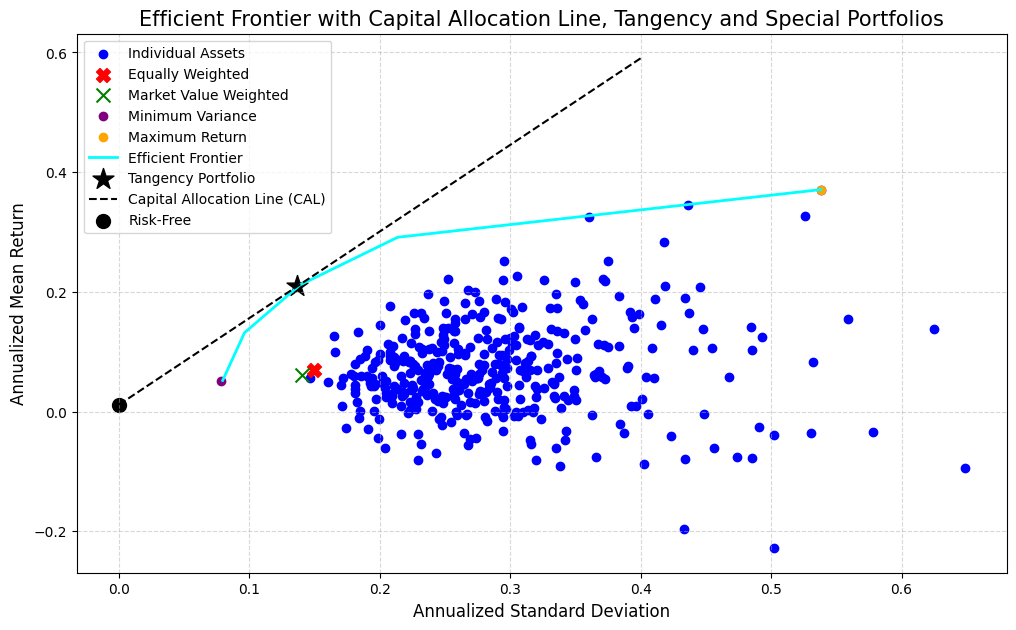

In [70]:

# Final comprehensive plot
plt.figure(figsize=(12, 7))

# Individual assets
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')

# Equally Weighted Portfolio
plt.scatter(ew_ann_std, ew_ann_ret, color='red', marker='X', s=100, label='Equally Weighted')

# Market Value Weighted Portfolio
plt.scatter(mw_ann_std, mw_ann_ret, color='green', marker='x', s=100, label='Market Value Weighted')

# Min Variance Portfolio
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance')

# Max Return Portfolio
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return')

# Efficient frontier
plt.plot(target_ann_std, target_ann_ret, color='cyan', linewidth=2, label='Efficient Frontier')

# Tangency Portfolio
plt.scatter(tan_vol, tan_ret, marker='*', color='black', s=250, label='Tangency Portfolio')

# Capital Allocation Line (CAL)
sigma_range = np.linspace(0, 0.4, 100)
cal_line = ann_rf + (tan_ret - ann_rf)/tan_vol * sigma_range
plt.plot(sigma_range, cal_line, color='black', linestyle='--', label='Capital Allocation Line (CAL)')

# Risk-Free asset
plt.scatter(0, ann_rf, color='black', marker='o', s=100, label='Risk-Free')

# Labels and title
plt.xlabel('Annualized Standard Deviation', fontsize=12)
plt.ylabel('Annualized Mean Return', fontsize=12)
plt.title('Efficient Frontier with Capital Allocation Line, Tangency and Special Portfolios', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [71]:
max_return_weights.max()

np.float64(1.0)

In [72]:
# Compute ex-post returns for each portfolio along the efficient frontier
ex_post_returns = []

for i in efficient_frontier:
    monthly_returns = df_ex3.pivot(index='year', columns='Name', values='pct_monthly_return')
    portfolio_returns = monthly_returns.dot(i)
    ex_post_returns.append(portfolio_returns)

# Calculate ex-post annualized average return, annualized volatility, and Sharpe ratio
ex_post_ann_ret = []
ex_post_ann_std = []
ex_post_sharpe = []

for returns in ex_post_returns:
    ann_ret = returns.mean() * 12
    ann_std = returns.std() * np.sqrt(12)
    sharpe_ratio = (ann_ret - ann_rf) / ann_std
    ex_post_ann_ret.append(ann_ret)
    ex_post_ann_std.append(ann_std)
    ex_post_sharpe.append(sharpe_ratio)

# Find the portfolio with the highest ex-ante and ex-post Sharpe ratio
max_ex_ante_sharpe_idx = np.argmax(target_ann_ret / target_ann_std)
max_ex_post_sharpe_idx = np.argmax(ex_post_sharpe)

'''# Plot the efficient frontier, individual assets, capital allocation line, and portfolios
plt.figure(figsize=(12, 7))

# Individual assets
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')

# Equally Weighted Portfolio
plt.scatter(ew_ann_std, ew_ann_ret, color='red', marker='X', s=100, label='Equally Weighted')

# Market Value Weighted Portfolio
plt.scatter(mw_ann_std, mw_ann_ret, color='green', marker='x', s=100, label='Market Value Weighted')
# Min Variance Portfolio
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance')

# Max Return Portfolio
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return')

# Efficient frontier
plt.plot(target_ann_std, target_ann_ret, color='cyan', linewidth=2, label='Efficient Frontier')

# Capital Allocation Line (CAL)
sigma_range = np.linspace(0, 0.4, 100)
cal_line = ann_rf + (tan_ret - ann_rf)/tan_vol * sigma_range
plt.plot(sigma_range, cal_line, color='black', linestyle='--', label='Capital Allocation Line (CAL)')

# Risk-Free asset
plt.scatter(0, ann_rf, color='black', marker='o', s=100, label='Risk-Free')
#Tangency Portfolio
plt.scatter(tan_vol, tan_ret, marker='*', color='black', s=150, label='Tangency Portfolio')


# Highlight the portfolios with the highest ex-ante and ex-post Sharpe ratio
plt.scatter(target_ann_std[max_ex_ante_sharpe_idx], target_ann_ret[max_ex_ante_sharpe_idx], color='brown', s=40, label='Max Ex-Ante Sharpe Ratio')
plt.scatter(ex_post_ann_std[max_ex_post_sharpe_idx], ex_post_ann_ret[max_ex_post_sharpe_idx], color='indigo', s=40, label='Max Ex-Post Sharpe Ratio')

# Labels and title
plt.xlabel('Annualized Standard Deviation', fontsize=12)
plt.ylabel('Annualized Mean Return', fontsize=12)
plt.title('Efficient Frontier with Capital Allocation Line, Tangency and Special Portfolios', fontsize=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()'''

# Print the performance metrics
print(f"Portfolio with highest ex-ante Sharpe ratio: {max_ex_ante_sharpe_idx}")
print(f"Ex-Ante Sharpe Ratio: {target_ann_ret[max_ex_ante_sharpe_idx] / target_ann_std[max_ex_ante_sharpe_idx]}")
print(f"Ex-Post Sharpe Ratio: {ex_post_sharpe[max_ex_ante_sharpe_idx]}")

print(f"Portfolio with highest ex-post Sharpe ratio: {max_ex_post_sharpe_idx}")
print(f"Ex-Ante Sharpe Ratio: {target_ann_ret[max_ex_post_sharpe_idx] / target_ann_std[max_ex_post_sharpe_idx]}")
print(f"Ex-Post Sharpe Ratio: {ex_post_sharpe[max_ex_post_sharpe_idx]}")

Portfolio with highest ex-ante Sharpe ratio: 2
Ex-Ante Sharpe Ratio: 1.524792467326605
Ex-Post Sharpe Ratio: 1.404655051232213
Portfolio with highest ex-post Sharpe ratio: 2
Ex-Ante Sharpe Ratio: 1.524792467326605
Ex-Post Sharpe Ratio: 1.404655051232213


# **Exercise 4**

In [73]:
# Setting df for ex 4 with the same companies as before
df_ex4 = pd.merge(monthly_return_melted, static, how='outer')
df_ex4 = df_ex4[df_ex4['Region'] == 'PAC']
df_ex4 = df_ex4[df_ex4['ISIN'].isin(interest_companies)]
df_ex4['year'] = pd.to_datetime(df_ex4['year'])

In [74]:
# Filtering by the interesting timeframe
df_ex4 = df_ex4[(df_ex4['year'] >= '2003-12-01') & (df_ex4['year'] <= '2024-12-31')]

In [75]:
# Computing the individual returns
df_ex4['pct_monthly_return'] = df_ex4.groupby('Name')['monthly_return'].pct_change()

In [76]:
df_ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
954,77 BANK,JP3352000008,2003-12-31,0.70,JP,PAC,NaN
955,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143
956,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303
957,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059
958,77 BANK,JP3352000008,2004-04-30,0.75,JP,PAC,-0.038462
...,...,...,...,...,...,...,...
770401,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717
770402,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326
770403,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572
770404,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543


In [77]:
# Drop December 2003
df_ex4 = df_ex4[df_ex4['year'] >= '2004-01-01']

In [78]:
df_ex4[df_ex4['monthly_return'].isna()]['Name'].unique()

array(['A2B AUSTRALIA DEAD - DELIST.12/04/24', 'AOZORA BANK',
       'BENESSE HOLDINGS DEAD - DELIST.17/05/24', 'CHINA MENGNIU DAIRY',
       'CLEANAWAY WASTE MANAGEMENT', 'CSR DEAD - DEAD.10/07/24', 'DENA',
       'ELEC.POWER DEV.', 'INPEX', 'J S R DEAD - DELIST.25/06/24',
       'LAWSON DEAD - DELIST.24/07/24',
       'LINK REAL ESTATE INVESTMENT TRUST', 'OTSUKA HOLDINGS',
       'PACIFIC BASIN SHIP.',
       'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23', 'SEEK',
       'SOUTHERN CROSS MEDIA GROUP', 'SUMCO', 'T & D HOLDINGS',
       'TOSHIBA DEAD - DELIST.20/12/23'], dtype=object)

In [79]:
# Individual handling of the 5 missings
'A2B AUSTRALIA DEAD - DELIST.12/04/24'
df_ex4['pct_monthly_return'].loc[2104] = -1.
df_ex4['pct_monthly_return'].loc[2105] = np.nan
df_ex4['pct_monthly_return'].loc[2106] = np.nan
df_ex4['pct_monthly_return'].loc[2107] = np.nan
df_ex4['pct_monthly_return'].loc[2108] = np.nan
df_ex4['pct_monthly_return'].loc[2109] = np.nan
df_ex4['pct_monthly_return'].loc[2110] = np.nan
df_ex4['pct_monthly_return'].loc[2111] = np.nan
df_ex4['pct_monthly_return'].loc[2112] = np.nan
'BENESSE HOLDINGS DEAD - DELIST.17/05/24'
df_ex4['pct_monthly_return'].loc[88477] = -1.
df_ex4['pct_monthly_return'].loc[88478] = np.nan
df_ex4['pct_monthly_return'].loc[88479] = np.nan
df_ex4['pct_monthly_return'].loc[88480] = np.nan
df_ex4['pct_monthly_return'].loc[88481] = np.nan
df_ex4['pct_monthly_return'].loc[88482] = np.nan
df_ex4['pct_monthly_return'].loc[88483] = np.nan
df_ex4['pct_monthly_return'].loc[88484] = np.nan
'CSR DEAD - DEAD.10/07/24'
df_ex4['pct_monthly_return'].loc[182401] = -1.
df_ex4['pct_monthly_return'].loc[182402] = np.nan
df_ex4['pct_monthly_return'].loc[182403] = np.nan
df_ex4['pct_monthly_return'].loc[182404] = np.nan
df_ex4['pct_monthly_return'].loc[182405] = np.nan
df_ex4['pct_monthly_return'].loc[182406] = np.nan
df_ex4['pct_monthly_return'].loc[182407] = np.nan
'J S R DEAD - DELIST.25/06/24'
df_ex4['pct_monthly_return'].loc[362998] = -1.
df_ex4['pct_monthly_return'].loc[362999] = np.nan
df_ex4['pct_monthly_return'].loc[363000] = np.nan
df_ex4['pct_monthly_return'].loc[363001] = np.nan
df_ex4['pct_monthly_return'].loc[363002] = np.nan
df_ex4['pct_monthly_return'].loc[363003] = np.nan
df_ex4['pct_monthly_return'].loc[363004] = np.nan
'LAWSON DEAD - DELIST.24/07/24'
df_ex4['pct_monthly_return'].loc[406186] = -1.
df_ex4['pct_monthly_return'].loc[406187] = np.nan
df_ex4['pct_monthly_return'].loc[406188] = np.nan
df_ex4['pct_monthly_return'].loc[406189] = np.nan
df_ex4['pct_monthly_return'].loc[406190] = np.nan
df_ex4['pct_monthly_return'].loc[406191] = np.nan
'SBI SHINSEI BANKLIMITED DEAD - DELIST.28/09/23'
df_ex4['pct_monthly_return'].loc[592512] = -1.
df_ex4['pct_monthly_return'].loc[592513] = np.nan
df_ex4['pct_monthly_return'].loc[592514] = np.nan
df_ex4['pct_monthly_return'].loc[592515] = np.nan
df_ex4['pct_monthly_return'].loc[592516] = np.nan
df_ex4['pct_monthly_return'].loc[592517] = np.nan
df_ex4['pct_monthly_return'].loc[592518] = np.nan
df_ex4['pct_monthly_return'].loc[592519] = np.nan
df_ex4['pct_monthly_return'].loc[592520] = np.nan
df_ex4['pct_monthly_return'].loc[592521] = np.nan
df_ex4['pct_monthly_return'].loc[592522] = np.nan
df_ex4['pct_monthly_return'].loc[592523] = np.nan
df_ex4['pct_monthly_return'].loc[592524] = np.nan
df_ex4['pct_monthly_return'].loc[592525] = np.nan
df_ex4['pct_monthly_return'].loc[592526] = np.nan
df_ex4['pct_monthly_return'].loc[592527] = np.nan
'TOSHIBA DEAD - DELIST.20/12/23'
df_ex4['pct_monthly_return'].loc[698819] = -1.
df_ex4['pct_monthly_return'].loc[698820] = np.nan
df_ex4['pct_monthly_return'].loc[698821] = np.nan
df_ex4['pct_monthly_return'].loc[698822] = np.nan
df_ex4['pct_monthly_return'].loc[698823] = np.nan
df_ex4['pct_monthly_return'].loc[698824] = np.nan
df_ex4['pct_monthly_return'].loc[698825] = np.nan
df_ex4['pct_monthly_return'].loc[698826] = np.nan
df_ex4['pct_monthly_return'].loc[698827] = np.nan
df_ex4['pct_monthly_return'].loc[698828] = np.nan
df_ex4['pct_monthly_return'].loc[698829] = np.nan
df_ex4['pct_monthly_return'].loc[698830] = np.nan
df_ex4['pct_monthly_return'].loc[698831] = np.nan


In [80]:
df_ex4[(df_ex4['Name'] == 'TOSHIBA DEAD - DELIST.20/12/23') & (df_ex4['monthly_return'].isna())]

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
698819,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2023-12-29,NaN,JP,PAC,-1.0
698820,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-01-31,NaN,JP,PAC,NaN
698821,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-02-29,NaN,JP,PAC,NaN
698822,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-03-29,NaN,JP,PAC,NaN
698823,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-04-30,NaN,JP,PAC,NaN
698824,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-05-31,NaN,JP,PAC,NaN
698825,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-06-28,NaN,JP,PAC,NaN
698826,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-07-31,NaN,JP,PAC,NaN
698827,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-08-30,NaN,JP,PAC,NaN
698828,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,2024-09-30,NaN,JP,PAC,NaN


In [81]:
df_ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
955,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143
956,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303
957,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059
958,77 BANK,JP3352000008,2004-04-30,0.75,JP,PAC,-0.038462
959,77 BANK,JP3352000008,2004-05-31,0.76,JP,PAC,0.013333
...,...,...,...,...,...,...,...
770401,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717
770402,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326
770403,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572
770404,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543


In [82]:
weights = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = df_ex4[df_ex4['year'] <= f'{time}-01-01']
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights.append(pf.x)



In [83]:
'''weights = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = df_ex4[df_ex4['year'] <= f'{time}-01-01']
    print('actual timeframe ', actual_timeframe)
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    print('cov_matrix ', cov_matrix)
    num_assets = len(cov_matrix)
    print('num_assets ', num_assets)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    print('constraints ',constraints)
    bounds = tuple((0, 1) for asset in range(num_assets))
    print('bounds ', bounds)
    init_guess = num_assets * [1. / num_assets]
    print('init_guess ', init_guess)
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights.append(pf.x)'''

"weights = []\n\nfor time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:\n    actual_timeframe = df_ex4[df_ex4['year'] <= f'{time}-01-01']\n    print('actual timeframe ', actual_timeframe)\n    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()\n    print('cov_matrix ', cov_matrix)\n    num_assets = len(cov_matrix)\n    print('num_assets ', num_assets)\n    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})\n    print('constraints ',constraints)\n    bounds = tuple((0, 1) for asset in range(num_assets))\n    print('bounds ', bounds)\n    init_guess = num_assets * [1. / num_assets]\n    print('init_guess ', init_guess)\n    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)\n    weights.append(pf.x)"

In [84]:
len(weights)

11

In [85]:
final_df = pd.DataFrame()

for year in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    actual_timeframe = df_ex4[df_ex4['year'].dt.year == year]
    names = pd.DataFrame(actual_timeframe['Name'].unique(), columns=['Name'])
    names['weight'] = weights[year-2014]
    merged = pd.merge(actual_timeframe, names, on='Name', how='outer')
    final_df = pd.concat([final_df, merged])


In [86]:
final_df['weighted_returns'] = final_df['pct_monthly_return'] * final_df['weight']

In [87]:
final_df

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,weight,weighted_returns
0,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412,0.0,-0.0
1,77 BANK,JP3352000008,2014-02-28,0.62,JP,PAC,-0.060606,0.0,-0.0
2,77 BANK,JP3352000008,2014-03-31,0.64,JP,PAC,0.032258,0.0,0.0
3,77 BANK,JP3352000008,2014-04-30,0.64,JP,PAC,0.000000,0.0,0.0
4,77 BANK,JP3352000008,2014-05-30,0.68,JP,PAC,0.062500,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4903,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,0.0,-0.0
4904,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,0.0,0.0
4905,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,0.0,0.0
4906,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,0.0,-0.0


In [88]:
reb_pf = final_df.groupby('year')['weighted_returns'].sum().reset_index()
reb_pf

,year,weighted_returns
0,2014-01-31,-0.029426
1,2014-02-28,0.038480
2,2014-03-31,0.002818
3,2014-04-30,-0.013110
4,2014-05-30,0.025891
...,...,...
127,2024-08-30,0.039012
128,2024-09-30,-0.001295
129,2024-10-31,-0.012843
130,2024-11-29,0.003443


In [89]:
# Statistics of interest Rebalanced Portfolio
# Annualized return
reb_ann_ret = reb_pf['weighted_returns'].mean() * 12
# Annualized std
reb_ann_std = reb_pf['weighted_returns'].std() * np.sqrt(12)
# Sharpe ratio
reb_sharpe = (reb_ann_ret - ann_rf)/ reb_ann_std
#min return
reb_min_ret = reb_pf['weighted_returns'].min()
#max return
reb_max_ret = reb_pf['weighted_returns'].max()


In [90]:
statistics = pd.DataFrame({'Portfolio': ['Equally Weighted', 'Market Value Weighted', 'Yearly Rebalanced'],
                           'Annualized Return': [ew_ann_ret, mw_ann_ret, reb_ann_ret],
                           'Annualized Standard Deviation': [ew_ann_std, mw_ann_std, reb_ann_std],
                           'Sharpe Ratio': [ew_sharpe, mw_sharpe, reb_sharpe],
                           'Min Return': [ew_min_ret, mw_min_ret, reb_min_ret],
                           'Max Return': [ew_max_ret, mw_max_ret, reb_max_ret]})
statistics

,Portfolio,Annualized Return,Annualized Standard Deviation,Sharpe Ratio,Min Return,Max Return
0,Equally Weighted,0.069011,0.149373,0.383879,-0.136916,0.132389
1,Market Value Weighted,0.061567,0.140286,0.355680,-0.115458,0.135156
2,Yearly Rebalanced,0.049445,0.110769,0.341027,-0.095761,0.102114


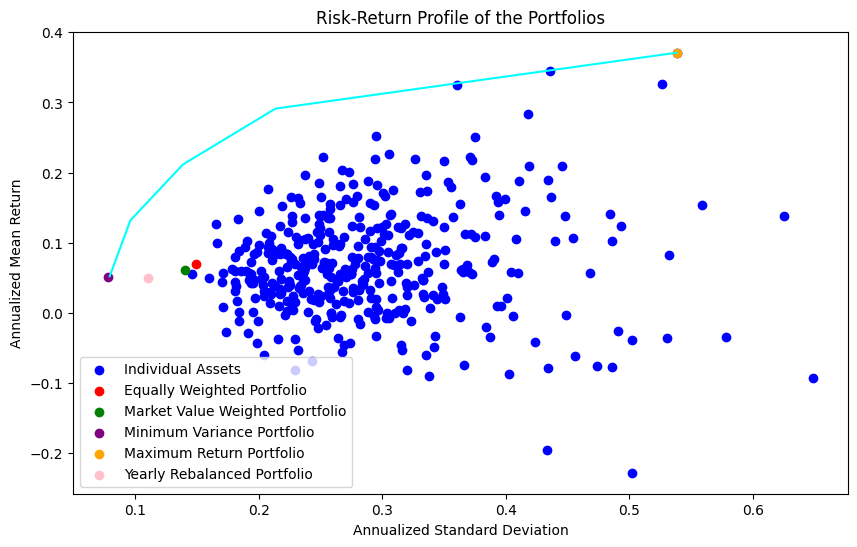

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(target_ann_std, target_ann_ret, color='cyan')
plt.scatter(annualization['annualized_std'], annualization['annualized_mean'], color='blue', label='Individual Assets')
plt.scatter(ew_ann_std, ew_ann_ret, color='red', label='Equally Weighted Portfolio')
plt.scatter(mw_ann_std, mw_ann_ret, color='green', label='Market Value Weighted Portfolio')
plt.scatter(minvar_ann_std, minvar_ann_ret, color='purple', label='Minimum Variance Portfolio')
plt.scatter(maxr_ann_std, maxr_ann_ret, color='orange', label='Maximum Return Portfolio')
plt.scatter(reb_ann_std, reb_ann_ret, color='pink', label='Yearly Rebalanced Portfolio')
plt.xlabel('Annualized Standard Deviation')
plt.ylabel('Annualized Mean Return')
plt.title('Risk-Return Profile of the Portfolios')
plt.legend()
plt.show()

In [92]:
# Install seaborn if not already installed
'''%pip install seaborn

import seaborn as sns'''

'%pip install seaborn\n\nimport seaborn as sns'

In [93]:
'''plt.figure()

sns.heatmap(monthly_return_melted.isnull(), cbar=False)
plt.show()
'''

'plt.figure()\n\nsns.heatmap(monthly_return_melted.isnull(), cbar=False)\nplt.show()\n'

In [94]:
print('Done!')

Done!


# **_HOMEWORK 2_**

In [95]:
df_ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return
955,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143
956,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303
957,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059
958,77 BANK,JP3352000008,2004-04-30,0.75,JP,PAC,-0.038462
959,77 BANK,JP3352000008,2004-05-31,0.76,JP,PAC,0.013333
...,...,...,...,...,...,...,...
770401,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717
770402,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326
770403,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572
770404,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543


In [96]:
monthly_return_melted['year'] = pd.to_datetime(monthly_return_melted['year'])
melted_escore['year'] = pd.to_datetime(melted_escore['year'])

# Sort by date before merging
df_ex4 = df_ex4.sort_values(by='year')
melted_escore = melted_escore.sort_values(by='year')

# Merge using closest past escore value
dfh2 = pd.merge_asof(
    df_ex4, 
    melted_escore, 
    on='year', 
    by=['Name', 'ISIN'], 
    direction='backward'  # Pick closest previous date
)

dfh2.head()


,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore
0,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143,NaN
1,COCHLEAR,AU000000COH5,2004-01-30,670.23,AU,PAC,0.038649,0.00
2,SUMITOMO HEAVY INDS.,JP3405400007,2004-01-30,1.96,JP,PAC,0.020833,0.00
3,COMFORTDELGRO CORPORATION,SG1N31909426,2004-01-30,69.31,SG,PAC,0.124980,0.00
4,SUMITOMO CHEMICAL,JP3401400001,2004-01-30,4.78,JP,PAC,0.004202,66.31


In [97]:
dfh2.sort_values(by=['Name', 'year'], inplace=True)

In [98]:
dfh2

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore
0,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143,NaN
440,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303,NaN
881,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059,NaN
1365,77 BANK,JP3352000008,2004-04-30,0.75,JP,PAC,-0.038462,NaN
2023,77 BANK,JP3352000008,2004-05-31,0.76,JP,PAC,0.013333,NaN
...,...,...,...,...,...,...,...,...
101221,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,81.68
101456,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,81.68
101841,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,81.68
102250,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,81.68


In [99]:
dfh2.shape

(103068, 8)

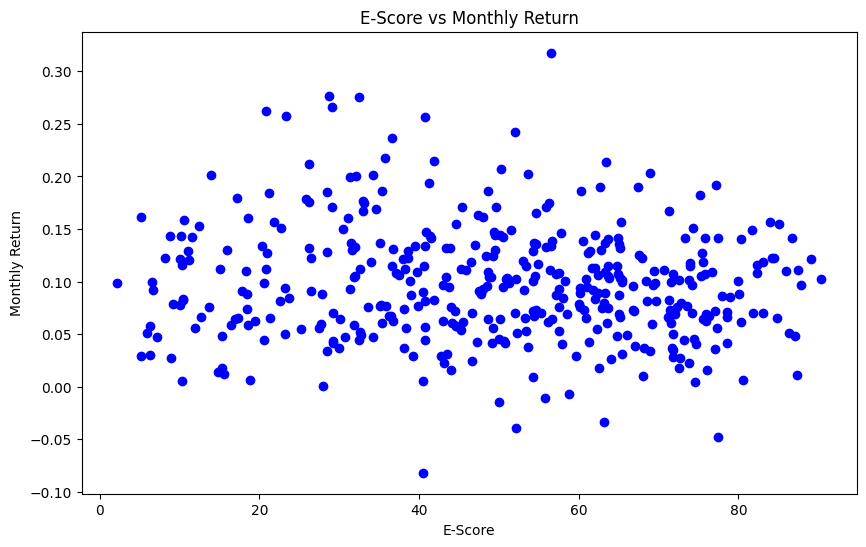

In [100]:
plt.figure(figsize=(10, 6))
plt.scatter(dfh2.groupby('Name')['escore'].mean(), dfh2.groupby('Name')['pct_monthly_return'].mean()*12, color='blue')
plt.xlabel('E-Score')
plt.ylabel('Monthly Return')
plt.title('E-Score vs Monthly Return')
plt.show()

In [101]:
dfh2['year_only'] = dfh2['year'].dt.year

In [102]:
dfh2 = dfh2[(dfh2['year_only'] >= 2013) & (dfh2['year_only'] <= 2023)]

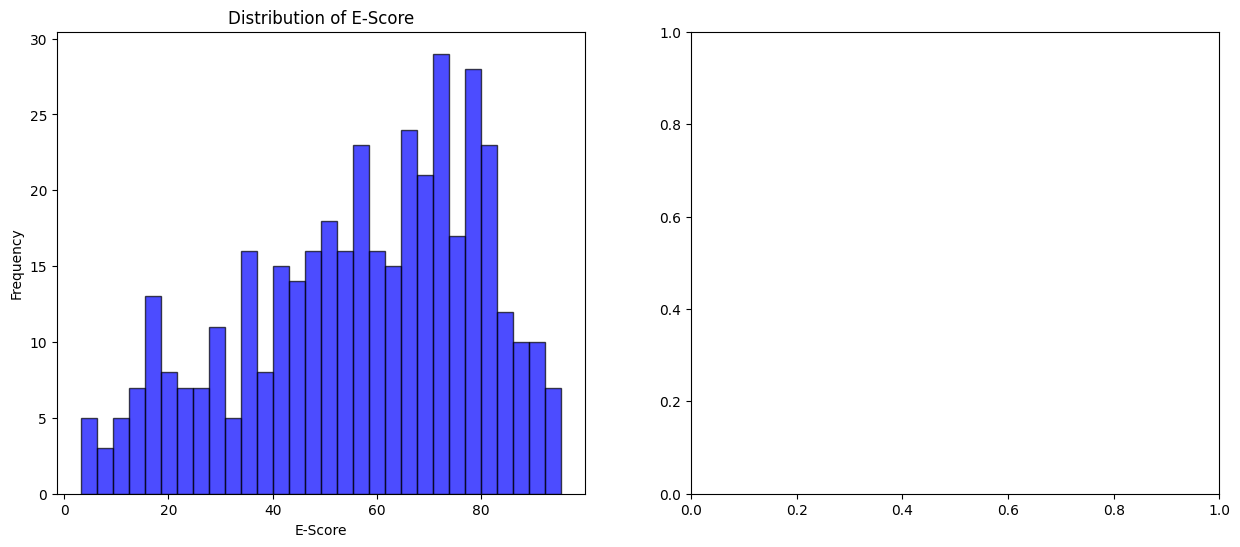

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].hist(dfh2.groupby('Name')['escore'].mean(), bins=30, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_xlabel('E-Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of E-Score')

#axs[1].hist(dfh2.groupby('year_only')['escore'].mean(), bins=30, color='red', alpha=0.7, edgecolor='black')
plt.show()

In [104]:
dfh2[dfh2['Name'] == '77 BANK'].tail(15)

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore,year_only
92120,77 BANK,JP3352000008,2022-10-31,0.43,JP,PAC,-0.022727,61.36,2022
92454,77 BANK,JP3352000008,2022-11-30,0.50,JP,PAC,0.162791,61.36,2022
93073,77 BANK,JP3352000008,2022-12-30,0.60,JP,PAC,0.200000,61.36,2022
93456,77 BANK,JP3352000008,2023-01-31,0.63,JP,PAC,0.050000,60.34,2023
93908,77 BANK,JP3352000008,2023-02-28,0.63,JP,PAC,0.000000,60.34,2023
94175,77 BANK,JP3352000008,2023-03-31,0.59,JP,PAC,-0.063492,60.34,2023
94672,77 BANK,JP3352000008,2023-04-28,0.59,JP,PAC,0.000000,60.34,2023
95150,77 BANK,JP3352000008,2023-05-31,0.64,JP,PAC,0.084746,60.34,2023
95482,77 BANK,JP3352000008,2023-06-30,0.65,JP,PAC,0.015625,60.34,2023
95774,77 BANK,JP3352000008,2023-07-31,0.78,JP,PAC,0.200000,60.34,2023


In [105]:
dfh2.groupby('Name')['escore'].mean()

Name
77 BANK                                 30.783636
A2B AUSTRALIA DEAD - DELIST.12/04/24    16.228182
ACOM                                    24.194545
ADVANTEST                               83.044545
AEON                                    84.964545
                                          ...    
YAMAHA                                  59.066364
YAMATO HDG.                             43.613636
YOKOGAWA ELECTRIC                       79.676364
YUE YUEN INDL.HDG.                      28.368182
YUEXIU PROPERTY COMPANY                 67.039091
Name: escore, Length: 409, dtype: float64

In [106]:
dftest = dfh2.groupby('year_only')['escore'].mean().reset_index()
dftest

,year_only,escore
0,2013,46.373594
1,2014,47.251320
2,2015,49.710831
3,2016,52.625428
4,2017,54.382200
5,2018,57.039389
6,2019,60.218826
7,2020,62.384719
8,2021,64.344670
9,2022,65.424303


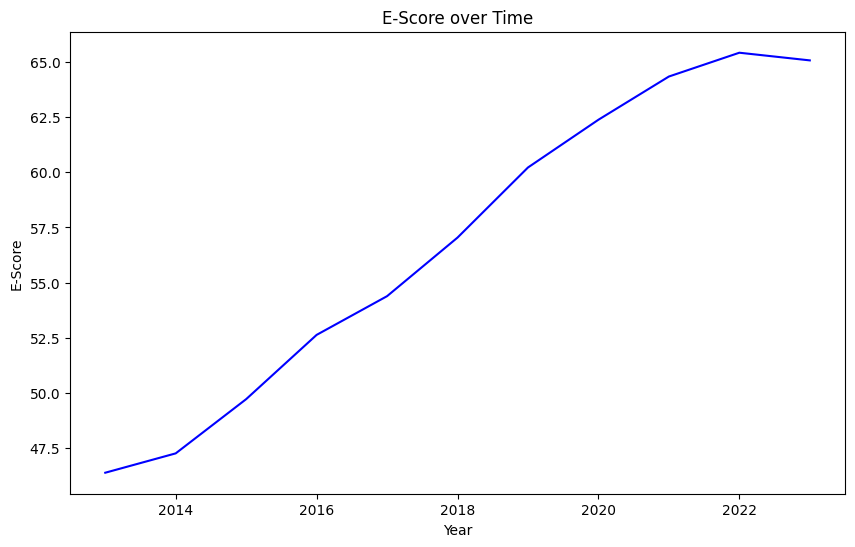

In [107]:
plt.figure(figsize=(10, 6))
plt.plot(dftest['year_only'], dftest['escore'], color='blue')
plt.xlabel('Year')
plt.ylabel('E-Score')
plt.title('E-Score over Time')
plt.show()

In [108]:
dfh2.describe()

,year,monthly_return,pct_monthly_return,escore,year_only
count,53988,53983.000000,53985.000000,53988.000000,53988.000000
mean,2018-07-15 13:27:16.363636480,1247.507879,0.006881,56.802892,2018.000000
min,2013-01-31 00:00:00,0.030000,-1.000000,0.000000,2013.000000
25%,2015-10-22 12:00:00,4.690000,-0.042373,40.070000,2015.000000
50%,2018-07-15 00:00:00,16.910000,0.004717,61.730000,2018.000000
75%,2021-04-07 12:00:00,245.955000,0.053571,77.230000,2021.000000
max,2023-12-29 00:00:00,50224.400000,1.667961,98.210000,2023.000000
std,NaN,4306.188231,0.086467,25.363727,3.162307


## Exercise 2

In [109]:
efficient_frontier

[array([0.00000000e+00, 0.00000000e+00, 4.28357632e-18, 9.37456952e-19,
        8.29039298e-19, 2.48619230e-18, 1.90451308e-18, 2.98002948e-18,
        4.56134724e-19, 5.69835501e-02, 0.00000000e+00, 4.02402680e-18,
        1.63386136e-18, 3.07384861e-18, 5.23068010e-19, 2.68509601e-19,
        0.00000000e+00, 0.00000000e+00, 2.66614044e-18, 9.44952254e-19,
        5.64294968e-19, 5.40327417e-19, 3.70435184e-19, 0.00000000e+00,
        1.27767832e-19, 1.31697090e-02, 0.00000000e+00, 2.38264561e-18,
        7.64347559e-18, 0.00000000e+00, 1.17407630e-03, 3.57304417e-18,
        2.72079384e-18, 0.00000000e+00, 5.24682820e-18, 6.77076235e-19,
        3.65568146e-18, 0.00000000e+00, 1.72913129e-02, 3.84451663e-02,
        0.00000000e+00, 1.95885262e-18, 5.31856388e-04, 0.00000000e+00,
        0.00000000e+00, 2.87514848e-18, 1.49752736e-18, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.519526

In [110]:
dfh2_ex2 = dfh2[(dfh2['year'] >= '2014-01-01') & (dfh2['year'] <= '2023-12-31')]
dfh2_ex2.shape

(49080, 9)

In [111]:
df_ex3.shape

(49080, 9)

In [112]:
# Precompute the mean returns and the annualized mean returns
h2_ann_returns = (dfh2_ex2.groupby('Name')['pct_monthly_return'].mean().values) * 12

# Define the constraints function
def constraints(target):
    return [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.sum(x * h2_ann_returns) - target}]

# Compute the efficient frontier portfolios
h2_target_returns = np.linspace(minvar_ann_ret, maxr_ann_ret, 5)
efficient_frontier = []

for target in target_returns:
    result = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints(target))
    efficient_frontier.append(result.x)

# Convert the efficient frontier to a NumPy array for further processing if needed
efficient_frontier = np.array(efficient_frontier)

In [113]:
# Calculate the annualized return and standard deviation for each set of weights in the efficient frontier
h2_target_ann_ret = []
h2_target_escore = []

for w in efficient_frontier:
	target_ann_ret = np.sum(w * dfh2_ex2.groupby('Name')['pct_monthly_return'].mean().values)*12
	target_escore = np.sum(w * dfh2_ex2.groupby('Name')['escore'].mean().values)
	h2_target_ann_ret.append(target_ann_ret)
	h2_target_escore.append(target_escore)

# Convert lists to numpy arrays
h2_target_ann_ret = np.array(h2_target_ann_ret)
h2_target_escore = np.array(h2_target_escore)

In [114]:
h2_target_ann_ret

array([0.0512406 , 0.13116173, 0.21108286, 0.29100399, 0.37092513])

In [115]:
efficient_frontier

array([[3.50754314e-19, 1.90832519e-19, 0.00000000e+00, ...,
        1.54346778e-19, 0.00000000e+00, 5.28313157e-19],
       [2.77100952e-18, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.17790838e-17, 3.86364319e-18, 0.00000000e+00, ...,
        0.00000000e+00, 2.52469272e-18, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91997094e-17, 0.00000000e+00, 0.00000000e+00],
       [7.50415019e-16, 0.00000000e+00, 0.00000000e+00, ...,
        1.56750312e-17, 0.00000000e+00, 2.51869957e-16]], shape=(5, 409))

In [116]:
w_dfh2_ex2 = dfh2_ex2.groupby('Name')[['pct_monthly_return', 'escore']].mean().reset_index()

In [117]:
efficient_score = []
efficient_return = []
for i in range(len(efficient_frontier)):
    w_dfh2_ex2[f'weight_{i}'] = efficient_frontier[i]
    w_dfh2_ex2[f'w_escore_{i}'] = w_dfh2_ex2[f'weight_{i}'] * w_dfh2_ex2['escore']
    w_dfh2_ex2[f'w_return_{i}'] = w_dfh2_ex2[f'weight_{i}'] * w_dfh2_ex2['pct_monthly_return'] * 12
    efficient_score.append(w_dfh2_ex2[f'w_escore_{i}'].sum())
    efficient_return.append(w_dfh2_ex2[f'w_return_{i}'].sum())
    print(f'Portfolio {i+1} E-Score: {np.round(w_dfh2_ex2[f"w_escore_{i}"].sum(),2)} Return: {np.round(w_dfh2_ex2[f"w_return_{i}"].sum(),2)}')

Portfolio 1 E-Score: 61.89 Return: 0.05
Portfolio 2 E-Score: 56.44 Return: 0.13
Portfolio 3 E-Score: 55.67 Return: 0.21
Portfolio 4 E-Score: 62.87 Return: 0.29
Portfolio 5 E-Score: 75.5 Return: 0.37


In [118]:
efficient_score

[np.float64(61.89427758435582),
 np.float64(56.44009319945566),
 np.float64(55.6654361734106),
 np.float64(62.87367837272949),
 np.float64(75.49700000185773)]

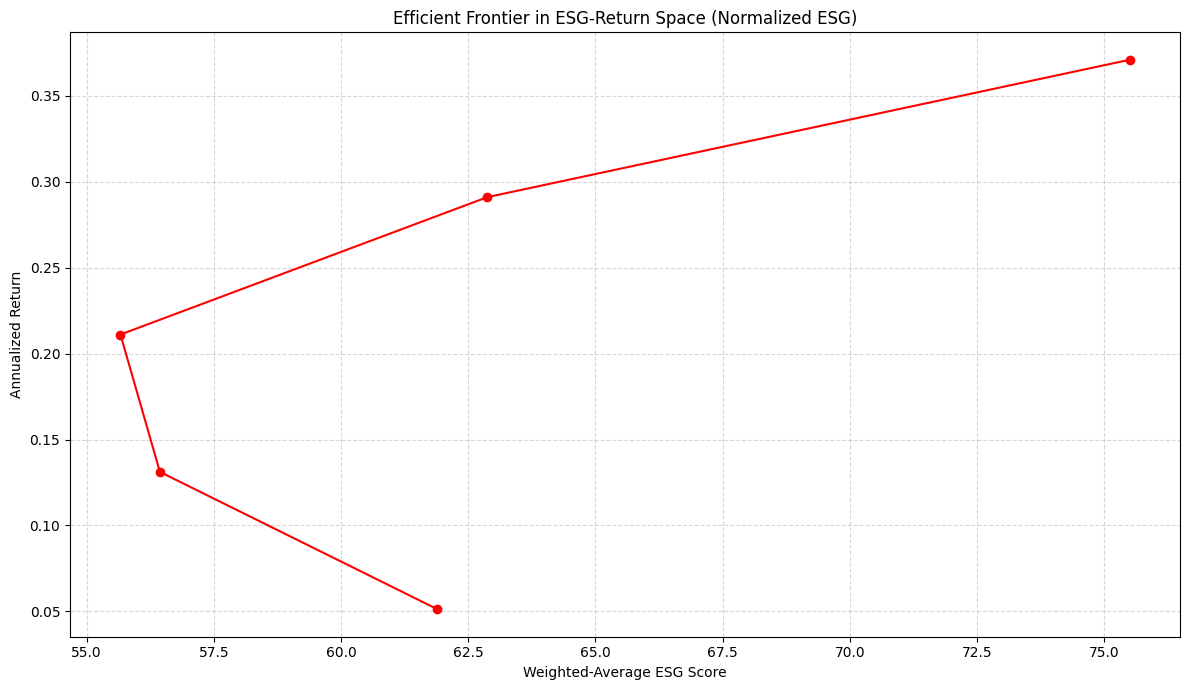

In [119]:
# Plotting
plt.figure(figsize=(12, 7))
plt.plot(efficient_score, efficient_return, marker='o', linestyle='-', color='red')
#plt.scatter(w_dfh2_ex2['escore'], w_dfh2_ex2['pct_monthly_return']*12, color='blue', label='Individual Assets')
plt.xlabel('Weighted-Average ESG Score')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier in ESG-Return Space (Normalized ESG)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [120]:
dfh2_ex2.groupby(['Name', 'ISIN'])['escore'].mean().reset_index().sort_values(by='escore', ascending=True).head(10)

,Name,ISIN,escore
360,TAKASHIMAYA,JP3456000003,3.448
335,SQUARE ENIX HOLDINGS,JP3164630000,3.524
173,KEIO,JP3277800003,3.752
244,NIPPON TELEVISION HDG.,JP3732200005,5.923
333,SOUTHERN CROSS MEDIA GROUP,AU000000SXL4,6.150
87,DENA,JP3548610009,7.097
261,ODAKYU ELECTRIC RY.,JP3196000008,7.369
393,USS,JP3944130008,9.472
362,TBS HOLDINGS,JP3588600001,10.517
293,SANKYO,JP3326410002,11.346


In [121]:
w_dfh2_ex2.sort_values(by=['weight_0', 'escore'], ascending=[False,  True]).head(10)

,Name,pct_monthly_return,escore,weight_0,w_escore_0,w_return_0,weight_1,w_escore_1,w_return_1,weight_2,w_escore_2,w_return_2,weight_3,w_escore_3,w_return_3,weight_4,w_escore_4,w_return_4
65,CLP HOLDINGS,0.004636,85.881,0.166523,14.301176,0.009263,1.217659e-01,1.045738e+01,6.773362e-03,2.462029e-02,2.114415e+00,1.369531e-03,0.000000e+00,0.000000e+00,0.000000e+00,8.851448e-16,7.601712e-14,4.923716e-17
282,POWER ASSETS HOLDINGS,0.005006,42.823,0.106854,4.575824,0.006419,9.967519e-02,4.268391e+00,5.987595e-03,2.570685e-02,1.100844e+00,1.544238e-03,6.149568e-18,2.633429e-16,3.694111e-19,1.019974e-15,4.367835e-14,6.127093e-17
191,LAWSON DEAD - DELIST.24/07/24,0.000714,67.126,0.091870,6.166877,0.000788,7.144378e-03,4.795735e-01,6.125050e-05,2.115529e-18,1.420070e-16,1.813694e-20,6.192257e-18,4.156615e-16,5.308774e-20,5.290462e-16,3.551276e-14,4.535643e-18
374,TOKYO GAS,0.002578,77.282,0.075530,5.837123,0.002337,2.137322e-02,1.651765e+00,6.611840e-04,9.743850e-19,7.530243e-17,3.014276e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
275,OSAKA GAS,0.003692,76.067,0.048463,3.686470,0.002147,1.408430e-02,1.071350e+00,6.240357e-04,8.575672e-19,6.523257e-17,3.799640e-20,0.000000e+00,0.000000e+00,0.000000e+00,6.207570e-16,4.721913e-14,2.750401e-17
395,WACOAL HDG.,0.004912,36.435,0.046502,1.694292,0.002741,3.017932e-02,1.099583e+00,1.778763e-03,4.336613e-19,1.580045e-17,2.555991e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
123,HANG SENG BANK,0.002573,87.554,0.040506,3.546503,0.001251,2.774089e-18,2.428826e-16,8.564707e-20,9.852908e-19,8.626615e-17,3.041981e-20,0.000000e+00,0.000000e+00,0.000000e+00,1.725933e-15,1.511123e-13,5.328634e-17
179,KINTETSU GROUP HDG.,0.001360,16.699,0.038163,0.637283,0.000623,9.959154e-20,1.663079e-18,1.625551e-21,0.000000e+00,0.000000e+00,0.000000e+00,1.327188e-17,2.216271e-16,2.166260e-19,0.000000e+00,0.000000e+00,0.000000e+00
38,CANON MARKETING JAPAN,0.010811,23.841,0.035603,0.848814,0.004619,6.256014e-02,1.491496e+00,8.115698e-03,3.806041e-02,9.073983e-01,4.937438e-03,0.000000e+00,0.000000e+00,0.000000e+00,4.438296e-16,1.058134e-14,5.757639e-17
338,SUBARU,0.001494,77.386,0.035178,2.722281,0.000631,5.953794e-19,4.607403e-17,1.067513e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.740758e-16,6.764123e-14,1.567215e-17


In [122]:
dfh2_ex2.groupby(['Name', 'ISIN'])['escore'].mean().reset_index().sort_values(by='escore', ascending=False).head(10)

,Name,ISIN,escore
303,SEKISUI CHEMICAL,JP3419400001,95.771
132,HITACHI,JP3788600009,95.163
211,MITSUBISHI ELECTRIC,JP3902400005,94.279
106,FUJI ELECTRIC,JP3820000002,94.057
182,KOMATSU,JP3304200003,93.623
232,NATIONAL AUS.BANK,AU000000NAB4,93.520
68,COMMONWEALTH BK.OF AUS.,AU000000CBA7,92.564
378,TOSHIBA DEAD - DELIST.20/12/23,JP3592200004,92.382
398,WESTPAC BANKING,AU000000WBC1,91.445
209,MIRVAC GROUP STAPLED UNITS,AU000000MGR9,91.301


## Exercise 3

In [123]:
dfh2

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore,year_only
44264,77 BANK,JP3352000008,2013-01-31,0.60,JP,PAC,0.071429,15.25,2013
44730,77 BANK,JP3352000008,2013-02-28,0.66,JP,PAC,0.100000,15.25,2013
45329,77 BANK,JP3352000008,2013-03-29,0.76,JP,PAC,0.151515,15.25,2013
45611,77 BANK,JP3352000008,2013-04-30,0.83,JP,PAC,0.092105,15.25,2013
46071,77 BANK,JP3352000008,2013-05-31,0.60,JP,PAC,-0.277108,15.25,2013
...,...,...,...,...,...,...,...,...,...
96325,YUEXIU PROPERTY COMPANY,HK0000745908,2023-08-31,62.82,HK,PAC,-0.055906,81.68,2023
96724,YUEXIU PROPERTY COMPANY,HK0000745908,2023-09-29,58.43,HK,PAC,-0.069882,81.68,2023
97140,YUEXIU PROPERTY COMPANY,HK0000745908,2023-10-31,54.23,HK,PAC,-0.071881,81.68,2023
97592,YUEXIU PROPERTY COMPANY,HK0000745908,2023-11-30,47.52,HK,PAC,-0.123732,81.68,2023


In [124]:
dfh2_ex3 = dfh2.groupby('Name')[['pct_monthly_return', 'escore']].mean().reset_index()
for i in range(len(weights)):
    dfh2_ex3[f'weight_{2014+i}'] = weights[i]
    dfh2_ex3[f'w_escore_{2014+i}'] = dfh2_ex3[f'weight_{2014+i}'] * dfh2_ex3['escore']
    dfh2_ex3[f'w_return_{2014+i}'] = dfh2_ex3[f'weight_{2014+i}'] * dfh2_ex3['pct_monthly_return'] * 12
    efficient_score.append(dfh2_ex3[f'w_escore_{2014+i}'].sum())
    efficient_return.append(dfh2_ex3[f'w_return_{2014+i}'].sum())
    print(f'Portfolio {i+2014} E-Score: {np.round(dfh2_ex3[f"w_escore_{2014+i}"].sum(),2)} Return: {np.round(dfh2_ex3[f"w_return_{2014+i}"].sum(),2)}')

Portfolio 2014 E-Score: 56.61 Return: 0.05
Portfolio 2015 E-Score: 56.76 Return: 0.06
Portfolio 2016 E-Score: 56.33 Return: 0.05
Portfolio 2017 E-Score: 56.44 Return: 0.05
Portfolio 2018 E-Score: 55.68 Return: 0.05
Portfolio 2019 E-Score: 58.96 Return: 0.05
Portfolio 2020 E-Score: 57.91 Return: 0.05
Portfolio 2021 E-Score: 61.14 Return: 0.06
Portfolio 2022 E-Score: 59.9 Return: 0.06
Portfolio 2023 E-Score: 60.76 Return: 0.06
Portfolio 2024 E-Score: 60.33 Return: 0.06


In [125]:
dfh2_ex3.head()

,Name,pct_monthly_return,escore,weight_2014,w_escore_2014,w_return_2014,weight_2015,w_escore_2015,w_return_2015,weight_2016,...,w_return_2021,weight_2022,w_escore_2022,w_return_2022,weight_2023,w_escore_2023,w_return_2023,weight_2024,w_escore_2024,w_return_2024
0,77 BANK,0.006879,30.783636,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.464911e-19,0.000000e+00,0.000000e+00,0.000000e+00,7.198218e-19,2.215873e-17,5.942298e-20,1.797364e-18,5.532940e-17,1.483766e-19
1,A2B AUSTRALIA DEAD - DELIST.12/04/24,0.003463,16.228182,0.000000e+00,0.000000e+00,0.000000e+00,6.410765e-20,1.040351e-18,2.663774e-21,1.180510e-18,...,0.000000e+00,5.366526e-19,8.708896e-18,2.229876e-20,0.000000e+00,0.000000e+00,0.000000e+00,6.267818e-19,1.017153e-17,2.604377e-20
2,ACOM,0.003928,24.194545,1.300369e-18,3.146185e-17,6.129005e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.402240e-19,5.812110e-18,1.132243e-20,0.000000e+00,0.000000e+00,0.000000e+00,1.164436e-18,2.817301e-17,5.488315e-20
3,ADVANTEST,0.024865,83.044545,0.000000e+00,0.000000e+00,0.000000e+00,1.557882e-18,1.293736e-16,4.648458e-19,8.231095e-20,...,1.236092e-18,1.485106e-18,1.233300e-16,4.431308e-19,0.000000e+00,0.000000e+00,0.000000e+00,6.030835e-19,5.008280e-17,1.799500e-19
4,AEON,0.008575,84.964545,4.918887e-18,4.179310e-16,5.061503e-19,1.044720e-19,8.876414e-18,1.075010e-20,0.000000e+00,...,8.016575e-19,9.121511e-19,7.750050e-17,9.385976e-20,0.000000e+00,0.000000e+00,0.000000e+00,4.904106e-18,4.166751e-16,5.046293e-19


In [126]:
dfh2_ex3['w_escore_2014'].sum()

np.float64(56.61042206973437)

In [127]:
dfh2_ex3

,Name,pct_monthly_return,escore,weight_2014,w_escore_2014,w_return_2014,weight_2015,w_escore_2015,w_return_2015,weight_2016,...,w_return_2021,weight_2022,w_escore_2022,w_return_2022,weight_2023,w_escore_2023,w_return_2023,weight_2024,w_escore_2024,w_return_2024
0,77 BANK,0.006879,30.783636,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.464911e-19,0.000000e+00,0.000000e+00,0.000000e+00,7.198218e-19,2.215873e-17,5.942298e-20,1.797364e-18,5.532940e-17,1.483766e-19
1,A2B AUSTRALIA DEAD - DELIST.12/04/24,0.003463,16.228182,0.000000e+00,0.000000e+00,0.000000e+00,6.410765e-20,1.040351e-18,2.663774e-21,1.180510e-18,...,0.000000e+00,5.366526e-19,8.708896e-18,2.229876e-20,0.000000e+00,0.000000e+00,0.000000e+00,6.267818e-19,1.017153e-17,2.604377e-20
2,ACOM,0.003928,24.194545,1.300369e-18,3.146185e-17,6.129005e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.402240e-19,5.812110e-18,1.132243e-20,0.000000e+00,0.000000e+00,0.000000e+00,1.164436e-18,2.817301e-17,5.488315e-20
3,ADVANTEST,0.024865,83.044545,0.000000e+00,0.000000e+00,0.000000e+00,1.557882e-18,1.293736e-16,4.648458e-19,8.231095e-20,...,1.236092e-18,1.485106e-18,1.233300e-16,4.431308e-19,0.000000e+00,0.000000e+00,0.000000e+00,6.030835e-19,5.008280e-17,1.799500e-19
4,AEON,0.008575,84.964545,4.918887e-18,4.179310e-16,5.061503e-19,1.044720e-19,8.876414e-18,1.075010e-20,0.000000e+00,...,8.016575e-19,9.121511e-19,7.750050e-17,9.385976e-20,0.000000e+00,0.000000e+00,0.000000e+00,4.904106e-18,4.166751e-16,5.046293e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,YAMAHA,0.010559,59.066364,4.229936e-19,2.498470e-17,5.359862e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.807001e-20,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
405,YAMATO HDG.,0.005295,43.613636,1.588845e-18,6.929530e-17,1.009462e-19,0.000000e+00,0.000000e+00,0.000000e+00,1.429038e-19,...,0.000000e+00,6.945739e-19,3.029289e-17,4.412930e-20,9.606970e-19,4.189949e-17,6.103726e-20,0.000000e+00,0.000000e+00,0.000000e+00
406,YOKOGAWA ELECTRIC,0.009021,79.676364,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.489611e-19,0.000000e+00,0.000000e+00,0.000000e+00,4.126034e-19,3.287474e-17,4.466539e-20,4.230705e-19,3.370872e-17,4.579848e-20
407,YUE YUEN INDL.HDG.,0.000712,28.368182,0.000000e+00,0.000000e+00,0.000000e+00,4.368390e-03,1.239233e-01,3.729825e-05,3.734856e-02,...,5.855511e-05,0.000000e+00,0.000000e+00,0.000000e+00,8.664346e-18,2.457917e-16,7.397805e-20,0.000000e+00,0.000000e+00,0.000000e+00


In [128]:
final_df #From H1 ex4

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,weight,weighted_returns
0,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412,0.0,-0.0
1,77 BANK,JP3352000008,2014-02-28,0.62,JP,PAC,-0.060606,0.0,-0.0
2,77 BANK,JP3352000008,2014-03-31,0.64,JP,PAC,0.032258,0.0,0.0
3,77 BANK,JP3352000008,2014-04-30,0.64,JP,PAC,0.000000,0.0,0.0
4,77 BANK,JP3352000008,2014-05-30,0.68,JP,PAC,0.062500,0.0,0.0
...,...,...,...,...,...,...,...,...,...
4903,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,0.0,-0.0
4904,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,0.0,0.0
4905,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,0.0,0.0
4906,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,0.0,-0.0


In [129]:
# Sort by date before merging
final_df = final_df.sort_values(by='year')
melted_escore = melted_escore.sort_values(by='year')

# Merge using closest past escore value
dfh2_ex3 = pd.merge_asof(
    final_df, 
    melted_escore, 
    on='year', 
    by=['Name', 'ISIN'], 
    direction='backward'  # Pick closest previous date
)

dfh2_ex3.head()


,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,weight,weighted_returns,escore
0,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412,0.000000e+00,-0.000000e+00,15.56
1,HACHIJUNI BANK,JP3769000005,2014-01-31,0.68,JP,PAC,-0.042254,0.000000e+00,-0.000000e+00,23.73
2,SUMCO,JP3322930003,2014-01-31,0.42,JP,PAC,-0.125000,3.204179e-19,-4.005224e-20,26.69
3,MITSUBISHI UFJ FINL.GP.,JP3902900004,2014-01-31,0.61,JP,PAC,-0.061538,0.000000e+00,-0.000000e+00,89.83
4,CHALLENGER,AU000000CGF5,2014-01-31,439.71,AU,PAC,-0.053512,0.000000e+00,-0.000000e+00,24.75


In [130]:
dfh2_ex3['weighted_escore'] = dfh2_ex3['escore'] * dfh2_ex3['weight']

In [131]:
dftest = dfh2_ex3.groupby('year')['weighted_escore'].sum().reset_index()
dftest

,year,weighted_escore
0,2014-01-31,47.320810
1,2014-02-28,47.320810
2,2014-03-31,47.320810
3,2014-04-30,47.320810
4,2014-05-30,47.320810
...,...,...
127,2024-08-30,65.666049
128,2024-09-30,65.666049
129,2024-10-31,65.666049
130,2024-11-29,65.666049


In [132]:
gmv_escore = dftest['weighted_escore'].mean()
gmv_escore

np.float64(58.61386048228413)

In [133]:
target_escore = 1.2 * gmv_escore
target_escore

np.float64(70.33663257874096)

In [134]:
# Sort by date before merging
df_ex4 = df_ex4.sort_values(by='year')
melted_escore = melted_escore.sort_values(by='year')

# Merge using closest past escore value
dfh2_ex3_opt = pd.merge_asof(
    df_ex4, 
    melted_escore, 
    on='year', 
    by=['Name', 'ISIN'], 
    direction='backward'  # Pick closest previous date
)

dfh2_ex3_opt.head()


,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore
0,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143,NaN
1,MITSUBISHI LOGISTICS,JP3902000003,2004-01-30,7.44,JP,PAC,0.029046,0.00
2,LEE & MAN PAPER MNFG.,KYG5427W1309,2004-01-30,18.34,HK,PAC,0.088427,NaN
3,MITSUBISHI HEAVY INDS.,JP3900000005,2004-01-30,2.22,JP,PAC,0.057143,34.66
4,MATSUKIYOKARA,JP3869010003,2004-01-30,2.54,JP,PAC,0.170507,NaN


In [135]:
'''constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda x: np.dot(x, list(dfh2_ex3_opt['escore'].values)) - dftest['weighted_escore'].values}]'''

"constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},\n               {'type': 'ineq', 'fun': lambda x: np.dot(x, list(dfh2_ex3_opt['escore'].values)) - dftest['weighted_escore'].values}]"

In [136]:
nddftest = dfh2_ex3_opt.groupby(['Name', 'year_only'])['escore'].mean().reset_index()

KeyError: 'year_only'

In [137]:
dftest['year_only'] = dftest['year'].dt.year
dftest

,year,weighted_escore,year_only
0,2014-01-31,47.320810,2014
1,2014-02-28,47.320810,2014
2,2014-03-31,47.320810,2014
3,2014-04-30,47.320810,2014
4,2014-05-30,47.320810,2014
...,...,...,...
127,2024-08-30,65.666049,2024
128,2024-09-30,65.666049,2024
129,2024-10-31,65.666049,2024
130,2024-11-29,65.666049,2024


In [138]:
dftest = dftest.groupby('year_only')['weighted_escore'].mean().reset_index()
dftest

,year_only,weighted_escore
0,2014,47.320810
1,2015,50.947613
2,2016,54.351096
3,2017,52.496515
4,2018,53.011462
5,2019,58.715954
6,2020,61.097442
7,2021,66.538311
8,2022,67.745252
9,2023,66.861963


In [139]:
dftest[dftest['year_only'] == 2014]['weighted_escore'].values

array([47.32081007])

In [140]:
'''constraints = (
            constraints,
            {'type': 'ineq', 'fun': lambda x: np.dot(x, list(dfh2_ex3_opt['escore'].values())) - dftest['weighted_escore'].values()}
        )'''

"constraints = (\n            constraints,\n            {'type': 'ineq', 'fun': lambda x: np.dot(x, list(dfh2_ex3_opt['escore'].values())) - dftest['weighted_escore'].values()}\n        )"

In [141]:
dfh2_ex3_opt.loc[dfh2_ex3_opt['escore'].isna(), 'escore'] = 0.

In [142]:
dfh2_ex3_opt

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore
0,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143,0.00
1,MITSUBISHI LOGISTICS,JP3902000003,2004-01-30,7.44,JP,PAC,0.029046,0.00
2,LEE & MAN PAPER MNFG.,KYG5427W1309,2004-01-30,18.34,HK,PAC,0.088427,0.00
3,MITSUBISHI HEAVY INDS.,JP3900000005,2004-01-30,2.22,JP,PAC,0.057143,34.66
4,MATSUKIYOKARA,JP3869010003,2004-01-30,2.54,JP,PAC,0.170507,0.00
...,...,...,...,...,...,...,...,...
103063,KINTETSU GROUP HDG.,JP3260800002,2024-12-31,1.55,JP,PAC,-0.012739,39.67
103064,MIZUHO FINL.GP.,JP3885780001,2024-12-31,0.61,JP,PAC,-0.016129,88.39
103065,ASAHI KASEI,JP3111200006,2024-12-31,11.42,JP,PAC,-0.022260,90.87
103066,TOYOTA INDS.,JP3634600005,2024-12-31,110.58,JP,PAC,0.102602,89.11


In [143]:
dfh2_ex3_opt['year_only'] = dfh2_ex3_opt['year'].dt.year

In [144]:
'''weights_120 = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= f'{time}-01-01']
    escore = dftest[dftest['year_only'] == int(time)]['weighted_escore'].values[0]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: np.dot(x, list(actual_timeframe.groupby('year_only')['escore'].mean().iloc[-1])) - 1.2*escore})
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    bounds = tuple((0, 1) for asset in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights_120.append(pf.x)'''

"weights_120 = []\n\nfor time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:\n    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= f'{time}-01-01']\n    escore = dftest[dftest['year_only'] == int(time)]['weighted_escore'].values[0]\n    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},\n                   {'type': 'ineq', 'fun': lambda x: np.dot(x, list(actual_timeframe.groupby('year_only')['escore'].mean().iloc[-1])) - 1.2*escore})\n    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()\n    num_assets = len(cov_matrix)\n    bounds = tuple((0, 1) for asset in range(num_assets))\n    init_guess = num_assets * [1. / num_assets]\n    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)\n    weights_120.append(pf.x)"

In [145]:
'''weights_120 = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= f'{time}-01-01']
    df_escore = actual_timeframe.groupby('year_only')['escore'].mean().reset_index()
    e_scores = df_escore[df_escore['year_only'] == int(time)]['escore'].values

    if e_scores.size == 0:
        # If e_scores is empty, skip the E-score constraint for this year
        print(f"Warning: E-scores are empty for year {time}. Skipping E-score constraint.")
        continue

    # Get the previous weighted E-score for the current year
    prev_weighted_E_score_value = test[test['year_only'] == int(time)]['escore'].values[0]

    # Add the E-score constraint to constraints
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.dot(x, e_scores) - 1.2 * prev_weighted_E_score_value}
    )

    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights_120.append(pf.x)'''

'weights_120 = []\n\nfor time in [\'2014\', \'2015\', \'2016\', \'2017\', \'2018\', \'2019\', \'2020\', \'2021\', \'2022\', \'2023\', \'2024\']:\n    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt[\'year\'] <= f\'{time}-01-01\']\n    df_escore = actual_timeframe.groupby(\'year_only\')[\'escore\'].mean().reset_index()\n    e_scores = df_escore[df_escore[\'year_only\'] == int(time)][\'escore\'].values\n\n    if e_scores.size == 0:\n        # If e_scores is empty, skip the E-score constraint for this year\n        print(f"Warning: E-scores are empty for year {time}. Skipping E-score constraint.")\n        continue\n\n    # Get the previous weighted E-score for the current year\n    prev_weighted_E_score_value = test[test[\'year_only\'] == int(time)][\'escore\'].values[0]\n\n    # Add the E-score constraint to constraints\n    constraints = (\n        {\'type\': \'eq\', \'fun\': lambda x: np.sum(x) - 1},\n        {\'type\': \'ineq\', \'fun\': lambda x: np.dot(x, e_scores) - 1.2 * prev_weight

In [146]:
nddftest

NameError: name 'nddftest' is not defined

In [147]:
dict_wescores = dict(nddftest.values)
dict_wescores

NameError: name 'nddftest' is not defined

In [148]:
actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= '2024-01-01']
actual_timeframe.sort_values(['Name', 'year']).head(3)

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore,year_only
0,77 BANK,JP3352000008,2004-01-30,0.66,JP,PAC,-0.057143,0.0,2004
709,77 BANK,JP3352000008,2004-02-27,0.68,JP,PAC,0.030303,0.0,2004
1033,77 BANK,JP3352000008,2004-03-31,0.78,JP,PAC,0.147059,0.0,2004


In [149]:
df_escore = actual_timeframe.groupby(['Name','year_only'])['escore'].mean().reset_index()
df_escore.tail(2)

,Name,year_only,escore
8178,YUEXIU PROPERTY COMPANY,2022,76.96
8179,YUEXIU PROPERTY COMPANY,2023,81.68


In [150]:
e_scores = df_escore[df_escore['year_only'] == int('2013')-1]['escore'].values
len(e_scores)

409

In [152]:
weights_gmv = []  # Stores original minimum variance portfolio weights
weights_improved = []  # Stores E-score improved portfolio weights
original_scores = []  # Stores E-scores of original portfolios
improved_scores = []  # Stores E-scores of improved portfolios

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= f'{time}-01-01']
    
    # Get E-scores for current year
    df_escore = actual_timeframe.groupby(['Name','year_only'])['escore'].mean().reset_index()
    e_scores = df_escore[df_escore['year_only'] == int(time)-1]['escore'].values
    
    if e_scores.size == 0:
        print(f"Warning: E-scores are empty for year {time}. Skipping this year.")
        continue
    
    # Calculate covariance matrix and set optimization parameters
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    
    # STEP 1: Calculate the original minimum variance portfolio
    constraints_gmv = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Weights sum to 1
    )
    
    result_gmv = minimize(portfolio_variance, init_guess, args=(cov_matrix,), 
                         method='SLSQP', bounds=bounds, constraints=constraints_gmv)
    
    gmv_weights = result_gmv.x
    weights_gmv.append(gmv_weights)
    
    # Calculate the E-score of the minimum variance portfolio
    gmv_escore = np.dot(gmv_weights, e_scores)
    original_scores.append(gmv_escore)
    
    # STEP 2: Create the improved portfolio with 20% higher E-score
    target_escore = 1.2 * gmv_escore
    
    constraints_improved = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'ineq', 'fun': lambda x: np.dot(x, e_scores) - target_escore}  # E-score constraint
    )
    
    result_improved = minimize(portfolio_variance, init_guess, args=(cov_matrix,), 
                              method='SLSQP', bounds=bounds, constraints=constraints_improved)
    
    improved_weights = result_improved.x
    weights_improved.append(improved_weights)
    
    # Calculate the E-score of the improved portfolio
    improved_escore = np.dot(improved_weights, e_scores)
    improved_scores.append(improved_escore)
    
    print(f"Year {time}:")
    print(f"  Original GMV E-score: {gmv_escore:.4f}")
    print(f"  Improved GMV E-score: {improved_escore:.4f}")
    print(f"  Improvement: {(improved_escore/gmv_escore - 1)*100:.2f}%")
    
    # For the most recent year, analyze which firms were excluded
    if time == '2024':
        # Identify companies that were significantly reduced or excluded
        weight_changes = improved_weights - gmv_weights
        
        # Create a DataFrame to analyze the changes
        changes_df = pd.DataFrame({
            'Name': cov_matrix.columns,
            'Original_Weight': gmv_weights,
            'Improved_Weight': improved_weights,
            'Weight_Change': weight_changes,
            'E_Score': e_scores
        })
        
        # Sort by weight change to see biggest reductions
        excluded_firms = changes_df[changes_df['Improved_Weight'] < 0.001].sort_values('Original_Weight', ascending=False)
        
        print("\nFirms excluded or significantly reduced in the improved portfolio:")
        print(excluded_firms[['Name', 'Original_Weight', 'Improved_Weight', 'E_Score']])
        
        # Sort by weight increase to see which firms gained weight
        increased_firms = changes_df[changes_df['Weight_Change'] > 0.01].sort_values('Weight_Change', ascending=False)
        
        print("\nFirms with increased weight in the improved portfolio:")
        print(increased_firms[['Name', 'Original_Weight', 'Improved_Weight', 'E_Score']])

Year 2014:
  Original GMV E-score: 46.3943
  Improved GMV E-score: 55.6732
  Improvement: 20.00%
Year 2015:
  Original GMV E-score: 48.6167
  Improved GMV E-score: 58.3400
  Improvement: 20.00%
Year 2016:
  Original GMV E-score: 50.6791
  Improved GMV E-score: 60.8150
  Improvement: 20.00%
Year 2017:
  Original GMV E-score: 54.6239
  Improved GMV E-score: 65.5487
  Improvement: 20.00%
Year 2018:
  Original GMV E-score: 52.0176
  Improved GMV E-score: 62.4212
  Improvement: 20.00%
Year 2019:
  Original GMV E-score: 55.8313
  Improved GMV E-score: 66.9976
  Improvement: 20.00%
Year 2020:
  Original GMV E-score: 57.4800
  Improved GMV E-score: 68.9760
  Improvement: 20.00%
Year 2021:
  Original GMV E-score: 63.4930
  Improved GMV E-score: 76.1917
  Improvement: 20.00%
Year 2022:
  Original GMV E-score: 65.3615
  Improved GMV E-score: 78.4338
  Improvement: 20.00%
Year 2023:
  Original GMV E-score: 67.6347
  Improved GMV E-score: 81.1616
  Improvement: 20.00%
Year 2024:
  Original GMV E-sc

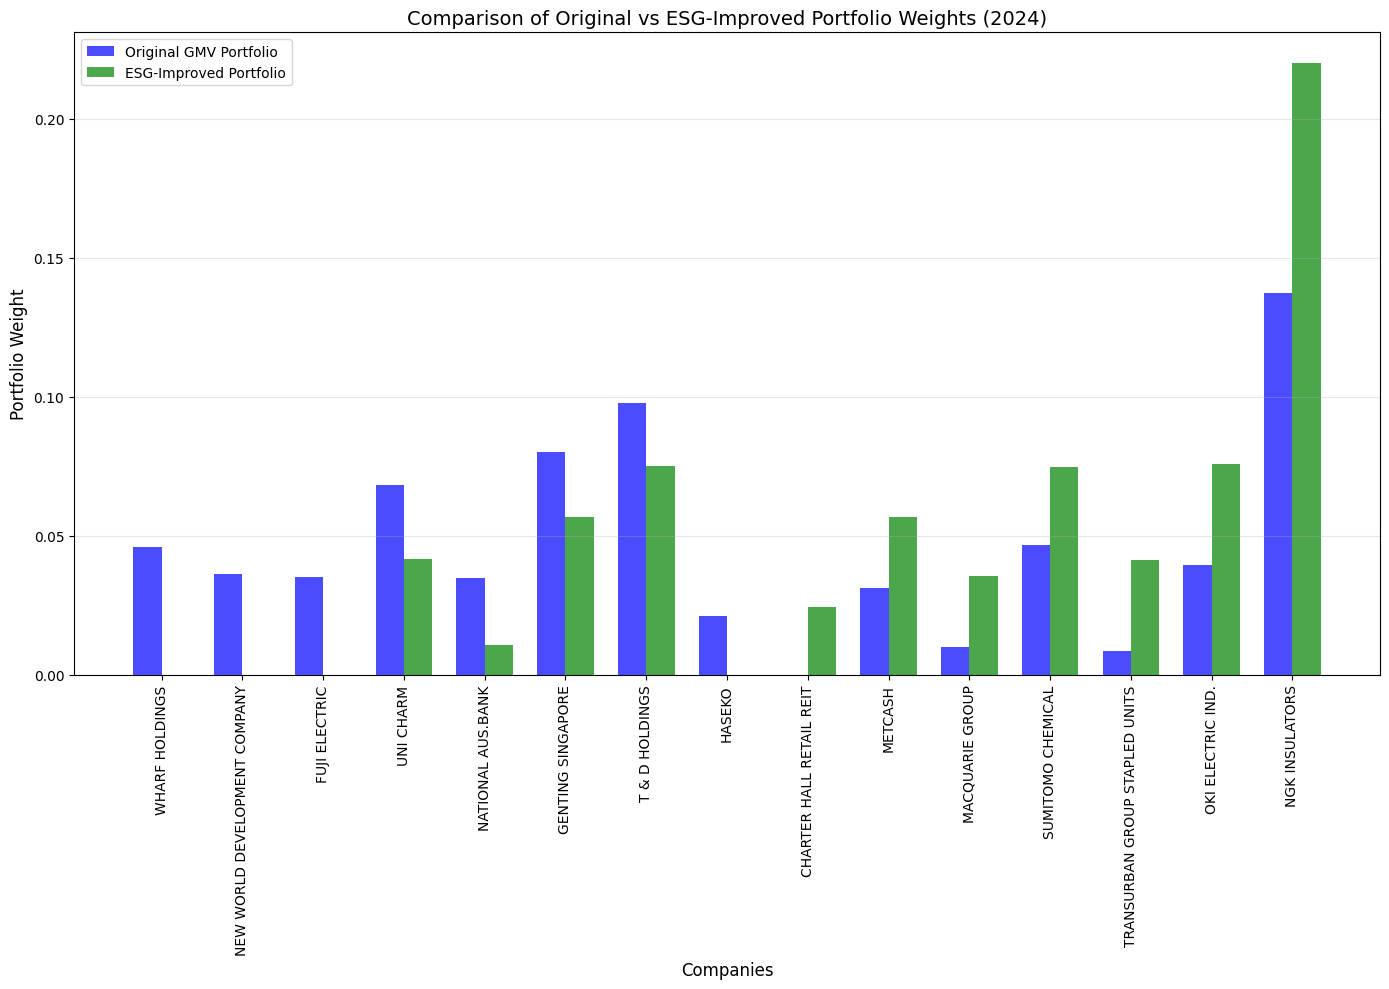

In [153]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Use the 2024 year data (last entry in the weights lists)
gmv_weights = weights_gmv[-1]
improved_weights = weights_improved[-1]

# Get company names from the most recent timeframe
actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= '2024-01-01']
companies = actual_timeframe['Name'].unique()

# Create a DataFrame to analyze the changes
changes_df = pd.DataFrame({
    'Name': companies,
    'Original_Weight': gmv_weights,
    'Improved_Weight': improved_weights,
    'Weight_Change': improved_weights - gmv_weights
})

# Filter to companies with significant weights in either portfolio
significant_changes = changes_df[
    (abs(changes_df['Original_Weight']) > 0.01) | 
    (abs(changes_df['Improved_Weight']) > 0.01)
].sort_values('Weight_Change')

# If there are too many companies, limit to most significant changes
if len(significant_changes) > 15:
    positive_changes = significant_changes[significant_changes['Weight_Change'] > 0].tail(7)
    negative_changes = significant_changes[significant_changes['Weight_Change'] < 0].head(8)
    significant_changes = pd.concat([negative_changes, positive_changes])

# Plot the comparison
plt.figure(figsize=(14, 10))
pos = np.arange(len(significant_changes))
width = 0.35

plt.bar(pos - width/2, significant_changes['Original_Weight'], width, 
        label='Original GMV Portfolio', color='blue', alpha=0.7)
plt.bar(pos + width/2, significant_changes['Improved_Weight'], width, 
        label='ESG-Improved Portfolio', color='green', alpha=0.7)

plt.xlabel('Companies', fontsize=12)
plt.ylabel('Portfolio Weight', fontsize=12)
plt.title('Comparison of Original vs ESG-Improved Portfolio Weights (2024)', fontsize=14)
plt.xticks(pos, significant_changes['Name'], rotation=90)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
'''weights_120 = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= f'{time}-01-01']
    df_escore = actual_timeframe.groupby(['Name','year_only'])['escore'].mean().reset_index()
    e_scores = df_escore[df_escore['year_only'] == int(time)-1]['escore'].values

    if e_scores.size == 0:
        # If e_scores is empty, skip the E-score constraint for this year
        print(f"Warning: E-scores are empty for year {time}. Skipping E-score constraint.")
        continue

    # Get the previous weighted E-score for the current year
    #prev_weighted_E_score_value = test[test['year_only'] == int(time)]['escore'].values[0]

    # Add the E-score constraint to constraints
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.dot(x, e_scores) - 1.2 * e_scores}
    )

    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights_120.append(pf.x)'''

In [478]:
'''weights_120 = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= f'{time}-01-01']
    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    bounds = tuple((0, 1) for _ in range(num_assets))  # Use `_` instead of `asset` since `asset` is not accessed
    init_guess = num_assets * [1. / num_assets]
    
    # Define constraints for the optimization
    escore_values = actual_timeframe.groupby('year')['escore'].mean().values  # Use the correct escore values for the timeframe
    optimization_constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.dot(x, escore_values) - escore_values*1.2}  # Ensure escore_values is used correctly
    )
    
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=optimization_constraints)
    weights_120.append(pf.x)'''

"weights_120 = []\n\nfor time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:\n    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= f'{time}-01-01']\n    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()\n    num_assets = len(cov_matrix)\n    bounds = tuple((0, 1) for _ in range(num_assets))  # Use `_` instead of `asset` since `asset` is not accessed\n    init_guess = num_assets * [1. / num_assets]\n    \n    # Define constraints for the optimization\n    escore_values = actual_timeframe.groupby('year')['escore'].mean().values  # Use the correct escore values for the timeframe\n    optimization_constraints = (\n        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},\n        {'type': 'ineq', 'fun': lambda x: np.dot(x, escore_values) - escore_values*1.2}  # Ensure escore_values is used correctly\n    )\n    \n    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method=

In [479]:
'''weights_120 = []

for time in ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']:
    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'] <= f'{time}-01-01']
    df_escore = actual_timeframe.groupby('year_only')['escore'].mean().reset_index()
    e_scores = df_escore[df_escore['year_only'] == int(time)]['escore'].values

    if e_scores.size == 0:
        # If e_scores is empty, skip the E-score constraint for this year
        print(f"Warning: E-scores are empty for year {time}. Skipping E-score constraint.")
        continue

    e_scores = e_scores[0]  # Access the first element after ensuring it's not empty

    # Add the E-score constraint to constraints
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: np.dot(x, e_scores) - 1.2 * e_scores}
    )

    cov_matrix = actual_timeframe.pivot(index='year', columns='Name', values='pct_monthly_return').cov()
    num_assets = len(cov_matrix)
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]
    pf = minimize(portfolio_variance, init_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    weights_120.append(pf.x)'''

'weights_120 = []\n\nfor time in [\'2014\', \'2015\', \'2016\', \'2017\', \'2018\', \'2019\', \'2020\', \'2021\', \'2022\', \'2023\', \'2024\']:\n    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt[\'year\'] <= f\'{time}-01-01\']\n    df_escore = actual_timeframe.groupby(\'year_only\')[\'escore\'].mean().reset_index()\n    e_scores = df_escore[df_escore[\'year_only\'] == int(time)][\'escore\'].values\n\n    if e_scores.size == 0:\n        # If e_scores is empty, skip the E-score constraint for this year\n        print(f"Warning: E-scores are empty for year {time}. Skipping E-score constraint.")\n        continue\n\n    e_scores = e_scores[0]  # Access the first element after ensuring it\'s not empty\n\n    # Add the E-score constraint to constraints\n    constraints = (\n        {\'type\': \'eq\', \'fun\': lambda x: np.sum(x) - 1},\n        {\'type\': \'ineq\', \'fun\': lambda x: np.dot(x, e_scores) - 1.2 * e_scores}\n    )\n\n    cov_matrix = actual_timeframe.pivot(index=\'year\', column

In [480]:
h2_ex3_finaldf = pd.DataFrame()

for year in [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    actual_timeframe = dfh2_ex3_opt[dfh2_ex3_opt['year'].dt.year == year]
    names = pd.DataFrame(actual_timeframe['Name'].unique(), columns=['Name'])
    names['weight'] = weights_120[year-2014]
    merged = pd.merge(actual_timeframe, names, on='Name', how='outer')
    h2_ex3_finaldf = pd.concat([h2_ex3_finaldf, merged])

In [481]:
h2_ex3_finaldf

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore,year_only,weight
0,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412,15.56,2014,5.613851e-17
1,77 BANK,JP3352000008,2014-02-28,0.62,JP,PAC,-0.060606,15.56,2014,5.613851e-17
2,77 BANK,JP3352000008,2014-03-31,0.64,JP,PAC,0.032258,15.56,2014,5.613851e-17
3,77 BANK,JP3352000008,2014-04-30,0.64,JP,PAC,0.000000,15.56,2014,5.613851e-17
4,77 BANK,JP3352000008,2014-05-30,0.68,JP,PAC,0.062500,15.56,2014,5.613851e-17
...,...,...,...,...,...,...,...,...,...,...
4903,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,81.68,2024,9.092875e-18
4904,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,81.68,2024,9.092875e-18
4905,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,81.68,2024,9.092875e-18
4906,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,81.68,2024,9.092875e-18


In [482]:
h2_ex3_finaldf['weighted_returns'] = h2_ex3_finaldf['pct_monthly_return'] * h2_ex3_finaldf['weight']
h2_ex3_finaldf['weighted_escores'] = h2_ex3_finaldf['escore'] * h2_ex3_finaldf['weight']
h2_ex3_finaldf['year_only'] = h2_ex3_finaldf['year'].dt.year

In [490]:
h2_ex3_finaldf.head(15)

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore,year_only,weight,weighted_returns,weighted_escores
0,77 BANK,JP3352000008,2014-01-31,0.66,JP,PAC,-0.029412,15.56,2014,5.613851e-17,-1.651133e-18,8.735152e-16
1,77 BANK,JP3352000008,2014-02-28,0.62,JP,PAC,-0.060606,15.56,2014,5.613851e-17,-3.402334e-18,8.735152e-16
2,77 BANK,JP3352000008,2014-03-31,0.64,JP,PAC,0.032258,15.56,2014,5.613851e-17,1.810920e-18,8.735152e-16
3,77 BANK,JP3352000008,2014-04-30,0.64,JP,PAC,0.000000,15.56,2014,5.613851e-17,0.000000e+00,8.735152e-16
4,77 BANK,JP3352000008,2014-05-30,0.68,JP,PAC,0.062500,15.56,2014,5.613851e-17,3.508657e-18,8.735152e-16
5,77 BANK,JP3352000008,2014-06-30,0.75,JP,PAC,0.102941,15.56,2014,5.613851e-17,5.778964e-18,8.735152e-16
6,77 BANK,JP3352000008,2014-07-31,0.75,JP,PAC,0.000000,15.56,2014,5.613851e-17,0.000000e+00,8.735152e-16
7,77 BANK,JP3352000008,2014-08-29,0.77,JP,PAC,0.026667,15.56,2014,5.613851e-17,1.497027e-18,8.735152e-16
8,77 BANK,JP3352000008,2014-09-30,0.76,JP,PAC,-0.012987,15.56,2014,5.613851e-17,-7.290715e-19,8.735152e-16
9,77 BANK,JP3352000008,2014-10-31,0.79,JP,PAC,0.039474,15.56,2014,5.613851e-17,2.215994e-18,8.735152e-16


In [483]:
h2_ex3_reb_pf = h2_ex3_reb_pf.groupby('year_only')[['weighted_escores']].mean().reset_index()

In [496]:
final_df.sort_values(['Name', 'year']).tail()

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,weight,weighted_returns
4903,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,1.205301e-18,-2.202296e-19
4904,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,1.205301e-18,6.813879e-19
4905,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,1.205301e-18,4.769671e-20
4906,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,1.205301e-18,-1.452901e-19
4907,YUEXIU PROPERTY COMPANY,HK0000745908,2024-12-31,36.22,HK,PAC,-0.099005,1.205301e-18,-1.193308e-19


In [497]:
h2_ex3_finaldf.tail()

,Name,ISIN,year,monthly_return,Country,Region,pct_monthly_return,escore,year_only,weight,weighted_returns,weighted_escores
4903,YUEXIU PROPERTY COMPANY,HK0000745908,2024-08-30,28.09,HK,PAC,-0.182717,81.68,2024,9.092875e-18,-1.661427e-18,7.427060e-16
4904,YUEXIU PROPERTY COMPANY,HK0000745908,2024-09-30,43.97,HK,PAC,0.565326,81.68,2024,9.092875e-18,5.140436e-18,7.427060e-16
4905,YUEXIU PROPERTY COMPANY,HK0000745908,2024-10-31,45.71,HK,PAC,0.039572,81.68,2024,9.092875e-18,3.598272e-19,7.427060e-16
4906,YUEXIU PROPERTY COMPANY,HK0000745908,2024-11-29,40.20,HK,PAC,-0.120543,81.68,2024,9.092875e-18,-1.096078e-18,7.427060e-16
4907,YUEXIU PROPERTY COMPANY,HK0000745908,2024-12-31,36.22,HK,PAC,-0.099005,81.68,2024,9.092875e-18,-9.002398e-19,7.427060e-16


In [491]:
h2_ex3_reb_pf

,year_only,weighted_escores
0,2014,47.251320
1,2015,49.710831
2,2016,52.625860
3,2017,54.382200
4,2018,57.039389
5,2019,60.218826
6,2020,62.384719
7,2021,64.344670
8,2022,65.424303
9,2023,65.076532


In [484]:
gmv_escore_opt = h2_ex3_reb_pf['weighted_escores'].mean()
gmv_escore_opt

58.503198155117886

In [485]:
gmv_escore

58.613860498504536

In [486]:
dftest

,year_only,weighted_escore
0,2014,47.320810
1,2015,50.947613
2,2016,54.351096
3,2017,52.496515
4,2018,53.011462
5,2019,58.715954
6,2020,61.097442
7,2021,66.538311
8,2022,67.745252
9,2023,66.861963


In [498]:
comparison = pd.merge(h2_ex3_reb_pf[['year_only', 'weighted_escores']], dftest, on='year_only')

In [499]:
comparison

,year_only,weighted_escores,weighted_escore
0,2014,47.251320,47.320810
1,2015,49.710831,50.947613
2,2016,52.625860,54.351096
3,2017,54.382200,52.496515
4,2018,57.039389,53.011462
5,2019,60.218826,58.715954
6,2020,62.384719,61.097442
7,2021,64.344670,66.538311
8,2022,65.424303,67.745252
9,2023,65.076532,66.861963
